## 1. Collect Basic Data

### Retrieve CryptoCurrency Market Data ###

In [1]:
import pandas as pd
import yfinance as yf
from functools import reduce
import requests
import time
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


CRYPTO = False

# Crypto Details
cryptoProducts = ["ETH-USD", "USDT-USD", "BTC-USD"]
availableGranularities = dict(zip(["1M", "5M", "15M", "1H", "6H", "1D"], [60, 300, 900, 3600, 21600, 86400]))

# Stock Details
dowTickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "NVDA"]  
sse50Tickers = ["600519.SS", "601318.SS", "601857.SS", "600036.SS", "600016.SS", "600000.SS"]  
sensexTickers = ["RELIANCE.BO", "TCS.BO", "INFY.BO", "ICICIBANK.BO", "SBIN.BO", "HINDUNILVR.BO"] 
ftse100Tickers = ["HSBA.L", "BP.L", "GSK.L", "SHEL.L", "BATS.L", "ULVR.L"]  
period = "1D"
indexProducts = dowTickers + sse50Tickers + sensexTickers + ftse100Tickers
productIds = indexProducts

if CRYPTO:
    productIds = cryptoProducts
    period = "1H"
    granularity = availableGranularities[period]
    API_THRESHOLD = 300 #Can only get 300 periods at a time from API
    PERIODS_WANTED = 10000

# not a chance
def retrieveCryptoData(productID, granularity, daysBack, endTime):
    API_URL = f"https://api.exchange.coinbase.com/products/{productID}/candles"
    daysBackDaysAgo = timedelta(days=daysBack)
    startTime = datetime.fromisoformat(endTime) - (granularity/86400) * daysBackDaysAgo

    # Convert to isoformat
    startTime = startTime.isoformat()

    # Set Request Parameters
    parameters = {
        "start" : startTime,
        "end" : endTime,
        "granularity" : str(granularity)
    }

    # Actually get data
    data = requests.get(API_URL, params = parameters, headers = {"content-type":"application/json"})
    df = pd.DataFrame(data.json(), columns=["time", "low", "high", "open", "close", "volume"])
    return df


def retrieveIndexData(ticker):
    # Define date range
    startDate = "2009-01-01"
    endDate = "2020-08-05"

    ohlcData = {}
    try:
        stockData = yf.download(ticker, start=startDate, end=endDate)
        ohlcData[ticker] = stockData[["Low", "High", "Open", "Close", "Volume"]]
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

    dfOhlc = pd.concat(ohlcData, axis=1)
    return dfOhlc


dataframes = dict()
RETRIEVE_DATA = False

if RETRIEVE_DATA:
    for productId in productIds:
        if CRYPTO:
            # Fetch PERIODS_WANTED periods of data
            end = (datetime.now()).isoformat()
            for batch in range(PERIODS_WANTED // API_THRESHOLD  + 1):
                amountToFetch = PERIODS_WANTED % API_THRESHOLD if batch == PERIODS_WANTED // API_THRESHOLD else API_THRESHOLD
                tempDF = retrieveCryptoData(productId, granularity, amountToFetch, end)
                timeInSeconds = (tempDF['time'].values)[-1]
                dt = datetime.fromtimestamp(timeInSeconds - granularity)
                end = dt.isoformat() + 'Z'
                value = dataframes.get(productId)
                if productId not in dataframes:
                    dataframes[productId] = tempDF[::-1]
                else:
                    dataframes[productId] = pd.concat([tempDF[::-1], dataframes[productId]])
        else:
            dataframe = retrieveIndexData(ticker=productId)
            columnNames = [value[1].lower() for value in list(dataframe.columns.values)]
            dataframe.columns = columnNames
            dataframes[productId] = dataframe
   
# Required for index data that pull stock data from different exchanges
def commonaliseData(data):
    commonDates = reduce(lambda x, y: x.intersection(y), [df.index for df in data.values()])
    for ticker, df in data.items():
        data[ticker] = df.reindex(commonDates)
        data[ticker]["Times"] = commonDates
    data = {ticker: df.dropna() for ticker, df in data.items()}
    PERIODS_WANTED = data.get(indexProducts[0]).shape[0]
    return data

if not CRYPTO and RETRIEVE_DATA:
    dataframes = commonaliseData(dataframes)

In [2]:
TEST_CORRECT_ORDER = False

if TEST_CORRECT_ORDER:
    testTime = dataframes[productIds[0]]['time'].values
    testTime -= testTime[0]
    plt.figure(figsize=(10, 6))
    plt.plot(testTime, color="blue")
    plt.title(f"Test Correct Order")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

## 2. Augment State Space (add indicators)

### Indicator 1: Exponential Moving Average ###

In [3]:
import matplotlib.pyplot as plt

def EMA(array, N):
    """
    EMA_t = (Price_t * α) + (EMA_(t-1) * (1 - α))
    where:
    EMA_t = Exponential Moving Average at time t
    Price_t = Price at time t
    α (alpha) = Smoothing factor, calculated as 2 / (N + 1)
    N = Number of periods
    """
    smoothingParameter = 2/(N + 1)
    finalArray = [array[0]]
    for i in range(1, len(array)):
        finalArray.append(array[i] * smoothingParameter + finalArray[i-1] * (1 - smoothingParameter))
    return np.array(finalArray)

# expMA = EMA(closingPrices, t)
# plt.figure(figsize=(10, 6))
# plt.plot(expMA, label=f"Exponential Moving Average: T={t}", color="red")
# plt.plot(closingPrices, label="Actual Closing Prices", color="blue")
# plt.title(f"Price Data")
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

### Indicator 2: Momemtum

In [4]:
def Momentum(array):
    # Percentage Change in Price/Time
    momentumArray = [(array[i] - array[i-1]) /array[i-1] for i in range(1, len(array))]
    momentumArray.insert(0, np.nan)
    return np.array(momentumArray)

# momentum = Momentum(closingPrices)
# plt.figure(figsize=(10, 6))
# plt.plot(momentum*100, color="green")
# plt.title(f"Momentum Data (as %)")
# plt.xlabel("Time")
# plt.ylabel("Momentum")
# plt.legend()
# plt.show()

### Indicator 3: Average True Range

In [5]:

def trueRange(high, low, close):
    # TR = Max[(H - L), |H - C|, |L - C|
    closing = np.insert(close, 0, np.nan, axis=0)[:len(close)]
    return np.maximum(high - low, np.abs(high - closing), np.abs(low - closing))

def averageTrueRange(high, low, close, n=14):
    trueRanges = trueRange(high, low, close)
    atr = np.empty_like(trueRanges)
    atr[:n] = np.nan  # First n values are NaN
    atr[n-1] = np.mean(trueRanges[:n])  # Initial ATR value (simple average of the first n TRs)
    for i in range(n+1, len(trueRanges)):
        atr[i] = (atr[i-1] * (n - 1) + trueRanges[i]) / n
    return atr

# aTRIndicator = averageTrueRange(highs, lows, closingPrices)
# plt.figure(figsize=(10, 6))
# plt.plot(aTRIndicator, color="Brown")
# plt.title(f"Average True Range over Time")
# plt.xlabel("Time")
# plt.ylabel("Average True Range")
# plt.legend()
# plt.show()

### Indicator 4: Commodity Channel Index

In [6]:
def commodityChannelIndex(high, low, close, n=20):
    # (Typical Price - 20_Day Moving Average) / .015 x Mean Deviation
    typicalPrices = (high + low + close) / 3
    
    movingAverage = np.full_like(high, np.nan)
    meanDeviation = np.full_like(high, np.nan)
    
    for i in range(n, len(typicalPrices)):
        movingAverage[i] = np.mean(typicalPrices[i-n:i])
        meanDeviation[i] = np.mean(np.abs(typicalPrices[i-n:i] - movingAverage[i]))
    
    cci = np.full_like(high, np.nan, dtype=np.float64)

    numerator = typicalPrices[n:] - movingAverage[n:]
    denominator = 0.015 * meanDeviation[n:]
    result = np.empty_like(numerator)

    np.divide(numerator, denominator, out=result, where=(denominator != 0))
    # a little hacky...
    result[denominator == 0] = 0

    cci[n:] = result
    return cci

# # CCI = commodityChannelIndex(highs, lows, closingPrices)
# # plt.figure(figsize=(10, 6))
# # plt.plot(CCI, color="black")
# # plt.title(f"Commodity Channel Index over Time")
# # plt.xlabel("Time")
# # plt.ylabel("Commodity Channel Index")
# # plt.legend()
# # plt.show()

### Indicator 5: MACD

In [7]:
"""
MACD = 12-day EMA - 26-day EMA
Signal Line = 9-day EMA of MACD
MACD Histogram = MACD - Signal Line
where EMA stands for Exponential Moving Average
"""

def MACD(array):
    return EMA(array, 12) - EMA(array, 26)

def MACDSignal(array):
    return EMA(MACD(array), 9)

MACDHistogram = lambda x : MACD(x) - MACDSignal(x)

# mACD = MACD(closingPrices)
# signalLine = MACDSignal(closingPrices)
# macdHistogram = MACDHistogram(mACD, signalLine)

# plt.figure(figsize=(10, 6))
# plt.plot(mACD, color="blue", label = "MACD Line")
# plt.plot(signalLine, color = "red", label = "Signal Line")
# plt.plot(macdHistogram, color = "black", label = "Histogram")
# plt.title(f"Moving Average Convergence-Divergence")
# plt.xlabel("Time")
# plt.ylabel("MACD")
# plt.legend()
# plt.show()

## 3. Collate All Features Into DataFrame

In [8]:
import os

CCI_T, ATR_T = 20, 14
if RETRIEVE_DATA:
    for product in productIds:
        df = dataframes[product]
        close = df["close"].values
        volume = df["volume"].values
        highs = df["high"].values
        lows = df["low"].values
        df['E_M_A'] = EMA(close, N=30)
        df['Momentum'] = Momentum(close)
        df['Av_True_Range'] = averageTrueRange(highs, lows, close, 14)
        df['CCI'] = commodityChannelIndex(highs, lows, close, 20)
        df['MACDHist'] = MACDHistogram(close)
        df["Return"] = df["close"].pct_change().fillna(0)
        # Reset Indexes
        df = df.drop(columns=['open', 'high', 'volume', 'low'])
        df = df.reset_index(drop=True)
        dataframes[product] = df
        if not os.path.exists("CSVs/"):
            os.makedirs("CSVs/")
        df.to_csv(f"CSVs/{product}_{period}_periods.csv", sep='\t')
else:
    for productId in productIds:
        df = pd.read_csv(f"CSVs/{productId}_{period}_periods.csv", sep='\t')
        dataframes[productId] = df.iloc[:, 1:]  # Drops the first column

times = None
for product in productIds:
    df = dataframes[product]
    df = df.iloc[max(ATR_T, CCI_T):]
    times = df['Times']
    dataframes[product] = df.drop('Times', axis=1)

## 4. Environment and Training Process

### Comparison Strategies

In [9]:
sse50BuyAndHold =  np.array([0] + [1/len(sse50Tickers) if i in sse50Tickers else 0 for i in productIds])
sensexBuyAndHold = np.array([0] + [1/len(sensexTickers) if i in sensexTickers else 0 for i in productIds])
ftse100BuyAndHold = np.array([0] + [1/len(ftse100Tickers) if i in ftse100Tickers else 0 for i in productIds])
dowBuyAndHold = np.array([0] + [1/len(dowTickers) if i in dowTickers else 0 for i in productIds])
buyAndHoldAll = np.array([0] + [1/(len(productIds)) for i in productIds])

#Non
NON_RL_COMPARISON_STRATEGIES = {
    "SSEBuyAndHold" : sse50BuyAndHold,
    "SENSEXBuyAndHold" : sensexBuyAndHold,
    "FTSEBuyAndHold" : ftse100BuyAndHold,
    "DOWBuyAndHold" : dowBuyAndHold,
    "BuyAndHoldAll" : buyAndHoldAll
}

### Hyperparameters (most of them)

In [10]:
from collections import defaultdict


NUMBER_OF_ASSETS = len(productIds)
NUMBER_OF_FEATURES = 1 + (len((list(dataframes.values())[0]).columns)) * len(productIds)
if not CRYPTO:
    PERIODS_WANTED = list(dataframes.values())[0].shape[0]
EXPERIMENTS = 2
TRAINING_PERIODS = int(PERIODS_WANTED / EXPERIMENTS) # will probably have to change this to times
TIME_WINDOW = 30
LEARNING_FREQUENCIES = (TRAINING_PERIODS / np.array([10, 20, 30, 40])).astype(int)
START_CASH = 1000000
LSTMHIDDENSIZE = 128
AGENT_RISK_AVERSIONS = np.array([1, 2, 3, 4]) / 2 #i know, this probably shouldn't go here
# STRATEGIES = ["SSEBuyAndHold", "SENSEXBuyAndHold", "FTSEBuyAndHold", "DOWBuyAndHold", "BuyAndHoldAll"]
STRATEGIES = ["PPOLSTM", "RANDOM"]
REPEATS = 5
LSTMOUTPUTSIZES = [64, 128, 256, 512]
STARTS = [0] + [i *  TRAINING_PERIODS + -TIME_WINDOW for i in range(1, EXPERIMENTS)]
PORTFOLIO_TRAJECTORIES = []
REWARD_FUNCTIONS = ["CVaR", "Standard Logarithmic Returns", "Differential Sharpe Ratio"]
NUMBER_OF_PARALLEL_ENVIRONMENTS = 4
averagePerformance = defaultdict(lambda: [])
allResults = defaultdict(lambda: [])

In [11]:
# Thing being tested
TESTING = {
    "RISK_AVERSION" : True,
    "LSTM_OUTPUT_SIZE" : False,
    "REWARD_FUNCTION" : False,
    "LEARNING_FREQUENCY": False
}

#### Some helper functions for metrics

In [12]:
from utils import tabulate_neatly

def printConfiguration(agent=None, freq=None):
    table = [["LSTM Hidden Size", "LSTM Output Size", "Learning Frequency", "Agent Risk Aversion"]]
    table.append([LSTMHIDDENSIZE, agent.state_n, freq, agent.riskAversion])
    tabulate_neatly(table, headers="firstrow", title=f"Configuration:")

def plotAllocations(allocations, title=None):
    categories = ['Cash'] + productIds
    plt.figure(figsize=(20,5))
    plt.bar(categories, allocations)
    plt.xlabel('Allocations')
    plt.tick_params(axis='x', labelsize=6)
    plt.ylabel('Proportion Allocated')
    plt.title('Allocations' if title == None else title)
    plt.show()

def generateConfigLabel(strategy, agent, episode, rewardFunction, freq):
    firstTag = f"Strategy: {strategy}" 
    lastTag = f"Experiment {episode + 1}"
    innerTag = None
    boole = (strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM")
    if TESTING["RISK_AVERSION"]:
        innerTag = (f"Risk Aversion: {agent.riskAversion}" if boole else "")
    elif TESTING["LSTM_OUTPUT_SIZE"]:
        innerTag = (f"LSTM Output Size: {agent.state_n}" if boole else "")
    elif TESTING["REWARD_FUNCTION"]:  
        innerTag = (f"Reward Function: {rewardFunction}" if boole else "")
    elif TESTING["LEARNING_FREQUENCY"]:  
        innerTag = (f"Update Frequency: {freq}" if boole else "")
    
    if (TESTING["RISK_AVERSION"] or TESTING["LSTM_OUTPUT_SIZE"] or TESTING["REWARD_FUNCTION"] or TESTING["LEARNING_FREQUENCY"]) and boole:
        firstTag, innerTag = innerTag, firstTag
    return firstTag + " | " +  innerTag + " | " + lastTag


### Actual Training

In [13]:
import torch
from PPO import PPOAgent
from LstmFeatureExtractor import LstmFeatureExtractor
from TimeSeriesEnvironment import TimeSeriesEnvironment
from scipy.special import softmax

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# Default Arguments Will need to be changed...
def trainingLoop(riskAversion=0, lstmOutputSize=192, rewardFunction="CVaR", freq=int(TRAINING_PERIODS/25)):
    for repeat in range(REPEATS):
        for strategy in STRATEGIES:
            if repeat > 0 and strategy != "PPOLSTM":
                continue
            for episode in range(EXPERIMENTS):
                start = episode *  TRAINING_PERIODS + (0 if episode == 0 else -TIME_WINDOW)
                featureExtractor = LstmFeatureExtractor(TIME_WINDOW, NUMBER_OF_FEATURES, 128, lstmOutputSize)
                agent = PPOAgent( 
                        state_n=lstmOutputSize, 
                        actions_n=len(productIds) + 1,
                        alpha=3e-4,
                        policyClip = 0.2,
                        gamma=0.99,
                        lstmHiddenSize=LSTMHIDDENSIZE,
                        actor_noise=0,
                        batch_size=384,
                        fc1_n=512,
                        fc2_n=384,
                        gaeLambda=0.98,
                        epochs=5,
                        riskAversion=riskAversion,
                    )
                env = TimeSeriesEnvironment(dataframes, start, TIME_WINDOW, TRAINING_PERIODS, START_CASH, riskAversion, 2.5e-4)
                env.reset()
                done = False
                doNothing = False
                while not done:
                    if strategy not in NON_RL_COMPARISON_STRATEGIES.keys():
                        if not env.getIsReady():
                            for warmUp in range(TIME_WINDOW):
                                """
                                'warm up' environment until there's enough data to calculate CVaR
                                """
                                allocations = np.random.normal(scale=1, size=len(productIds))
                                allocations = np.insert(allocations, 0, 1)
                                _, __, done, ___, ____ = env.step(softmax(allocations), False, rewardMethod = rewardFunction)
                            env.setIsReady(True)
                            continue
                    #If there's enough data left for the LSTM to process
                    observation = None
                    
                    if strategy == "PPOLSTM" or strategy == "TD3":
                        data = env.getData()
                        observation = featureExtractor.forward(torch.tensor(data, dtype=torch.float32).unsqueeze(0))
                        if strategy == "PPOLSTM":
                            action, probabilities, valuation = agent.select_action(observation)
                            action = action.numpy()
                        if doNothing:
                            allCashAction = np.array([1] + [0 for i in productIds])
                        else:
                            env.traded += 1
                    elif strategy == "RANDOM":
                        action = np.random.normal(0, 1, len(productIds) + 1)
                        env.traded += 1
                    else:
                        action = NON_RL_COMPARISON_STRATEGIES[strategy]
                        env.traded += 1
                    
                    if not doNothing:
                        finalAction = [0] + action if strategy in NON_RL_COMPARISON_STRATEGIES.keys() else softmax(action)
                    else:
                        finalAction = allCashAction

                    next, reward, done, __, info = env.step(finalAction, haveEffect = (env.timeStep)/TRAINING_PERIODS >= 2/3, rewardMethod=rewardFunction) # make this more efficient

                    if strategy == "PPOLSTM":
                        doNothing = info["turbulence_breached"]
                        if strategy == "PPOLSTM":
                            agent.store(
                                data,
                                action,
                                probabilities,
                                valuation,
                                float(reward),
                                done,
                            )
                        if (env.timeStep % freq) == 0:
                            agent.train(featureExtractor)
                    if done:
                        dataString  = generateConfigLabel(strategy, agent, episode, rewardFunction, freq)
                        metrics = env.getMetrics()
                        if strategy in NON_RL_COMPARISON_STRATEGIES.keys():
                            metrics["Average Profitability \nper Trade"] = "N/A"
                        table = [metrics.keys()]
                        table.append(metrics.values())
                        tabulate_neatly(table, headers="firstrow", title=f"{dataString}")
                        if strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM":
                            printConfiguration(agent, freq)
                            plotAllocations([0] + action if strategy in NON_RL_COMPARISON_STRATEGIES.keys() else softmax(action), "Final Allocations")
                        averagePerformance[dataString].append(env.PORTFOLIO_VALUES)
                        allResults[dataString].append(metrics)



TESTING RISK AVERSION


Risk Aversion: 0.5 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
49.49,53.48,39.3813,1352.18,0.1343,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,0.5


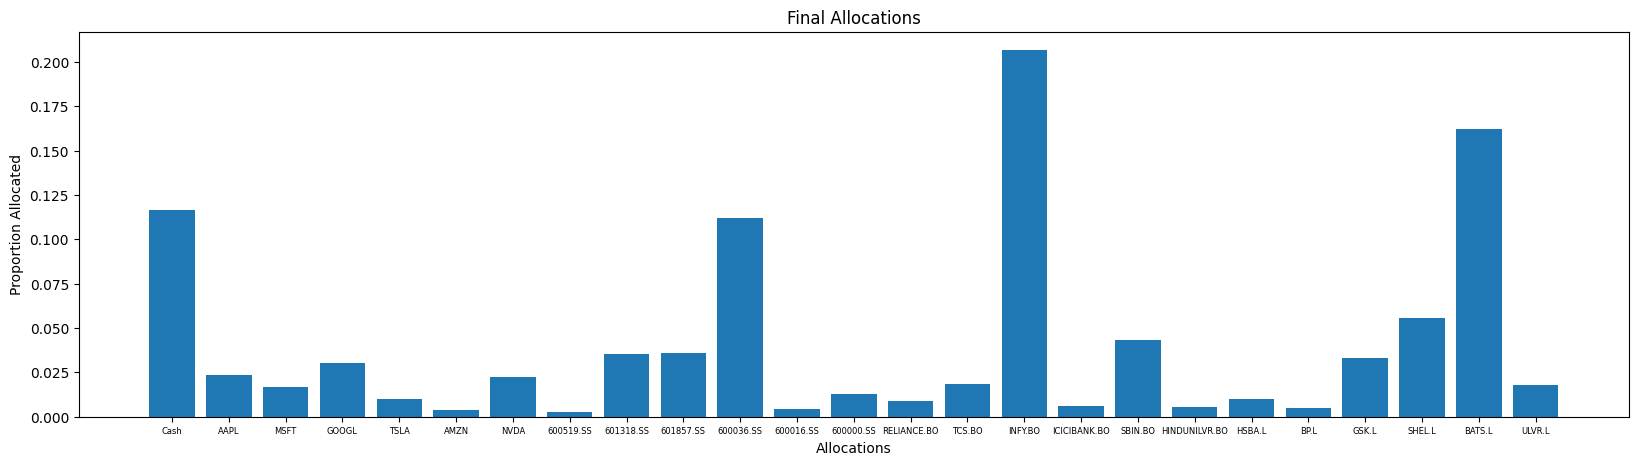

Risk Aversion: 0.5 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.39,29.51,44.0978,529.716,0.0361,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,0.5


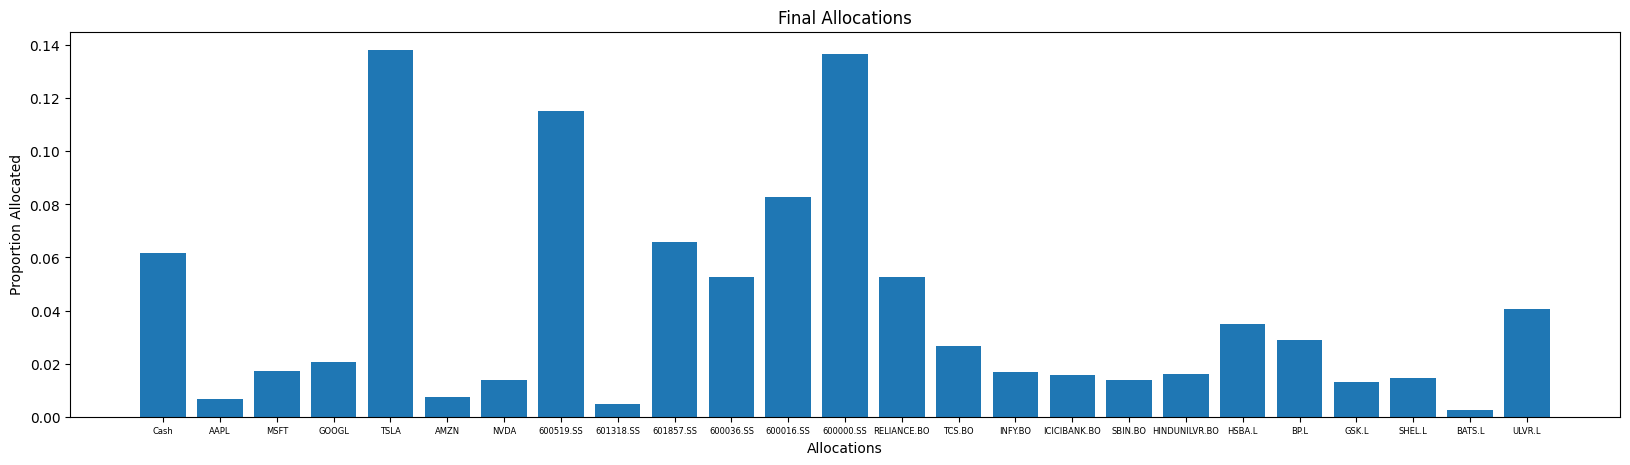

Strategy: RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
37.56,39.81,39.1373,1026.33,0.1108,1101


Strategy: RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.43,22.69,50.2687,503.439,0.0369,1101


Risk Aversion: 0.5 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
31.66,35.28,37.6068,864.995,0.1004,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,0.5


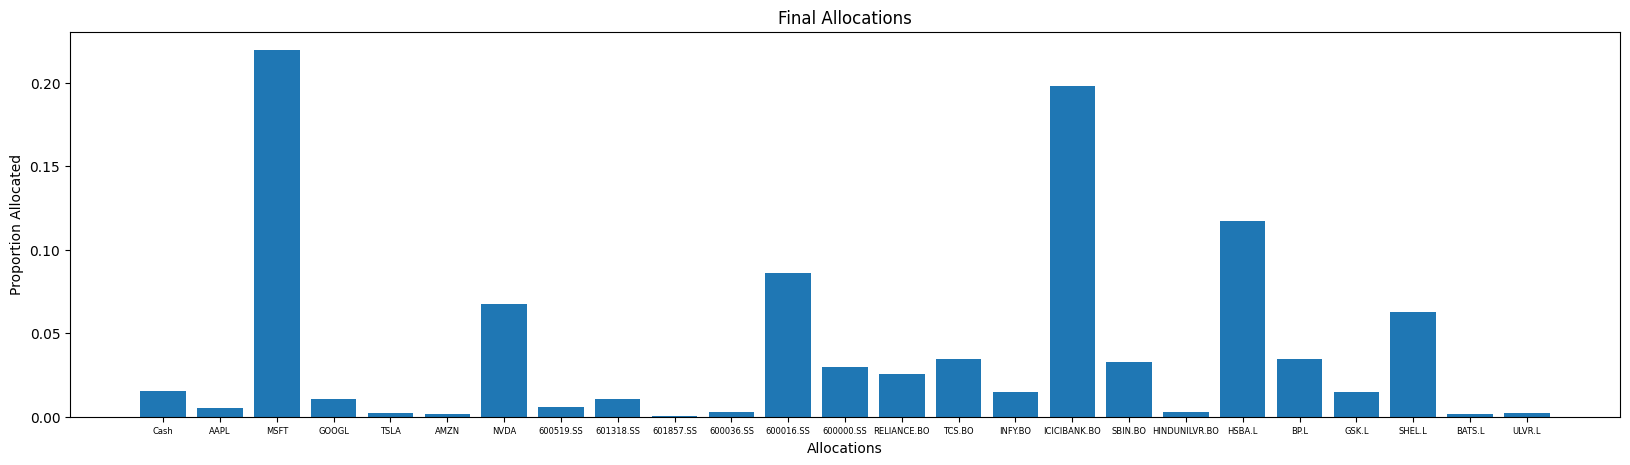

Risk Aversion: 0.5 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
10.57,19.52,50.1776,288.761,0.0232,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,0.5


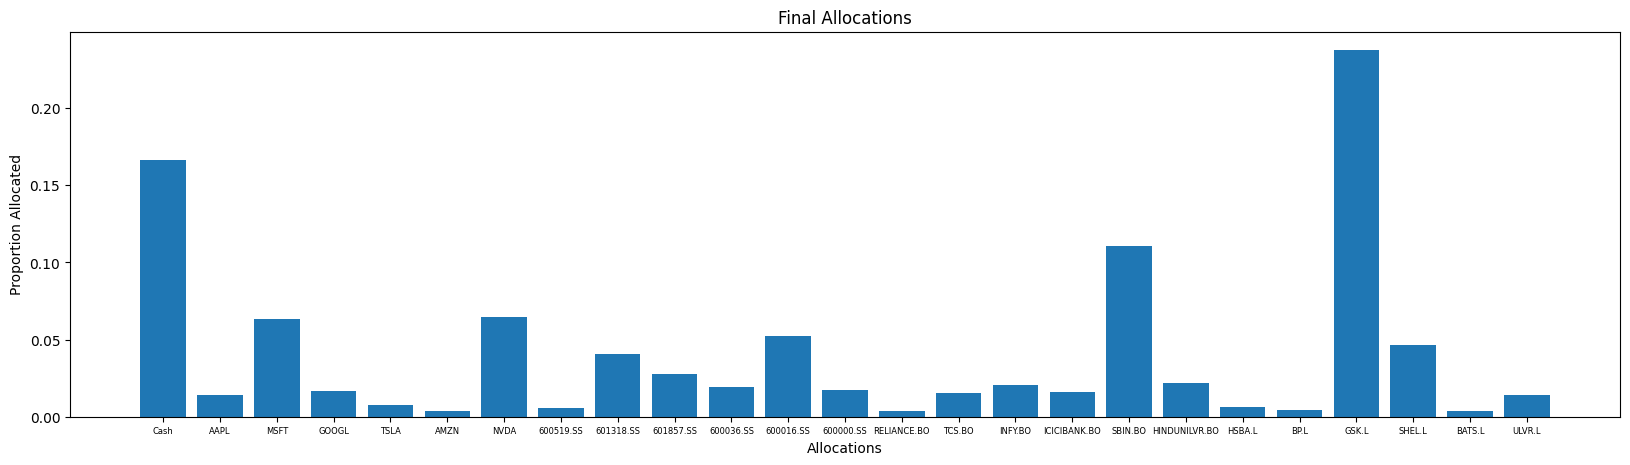

Risk Aversion: 0.5 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
28.59,33.41,31.2086,781.162,0.0833,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,0.5


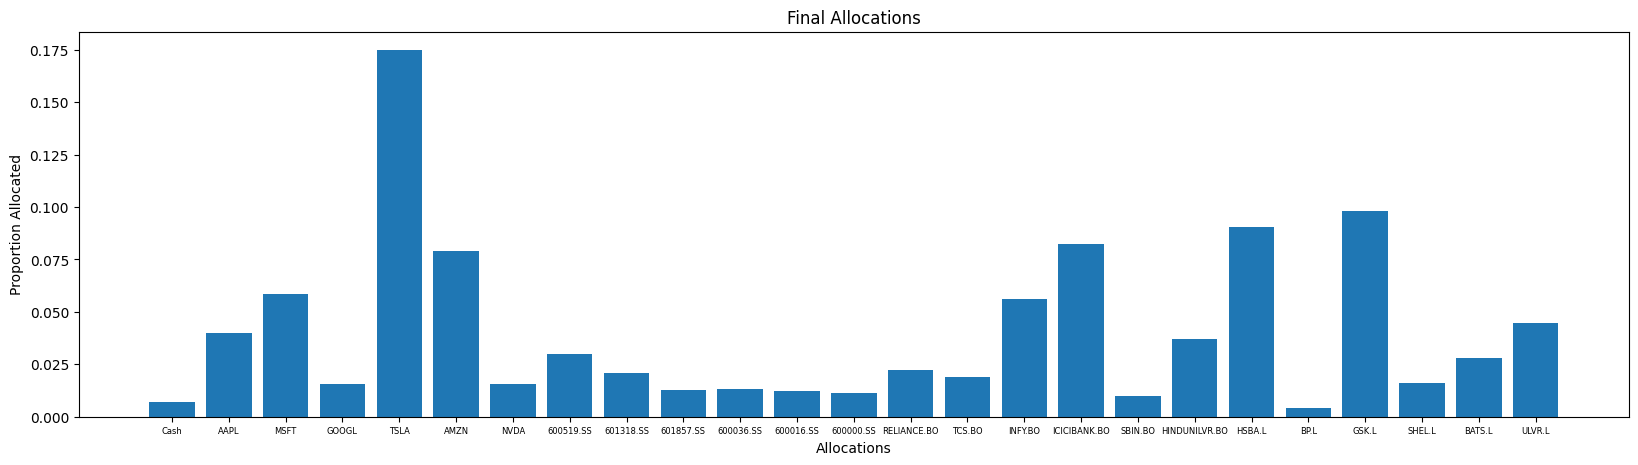

Risk Aversion: 0.5 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
14.35,25.63,47.6776,391.983,0.0271,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,0.5


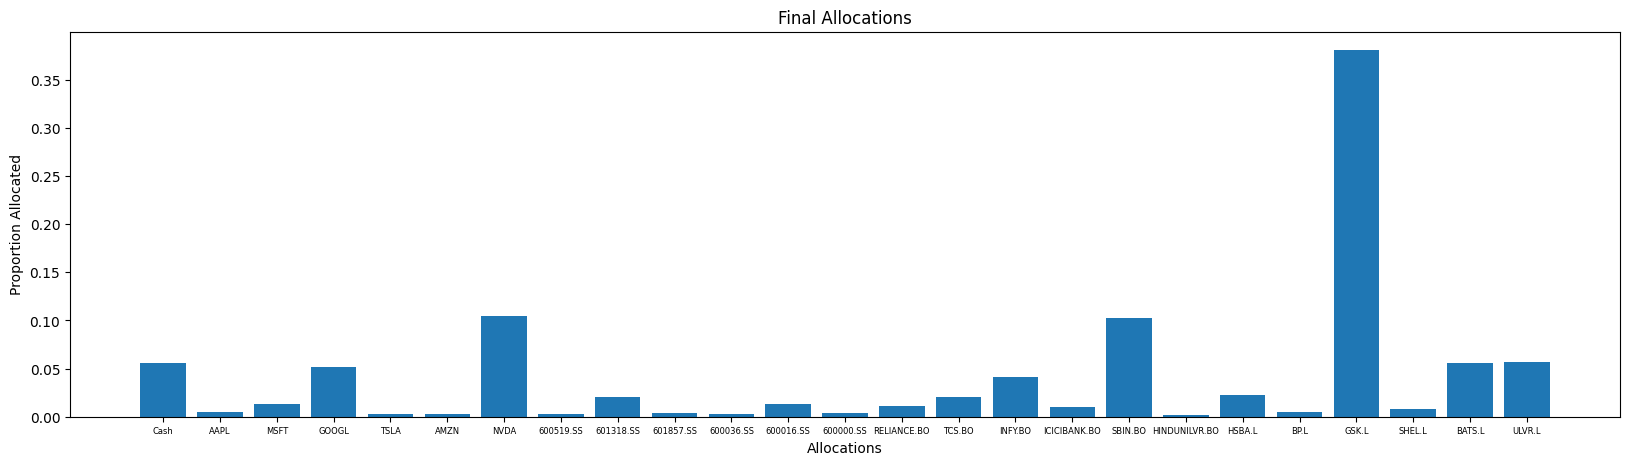

Risk Aversion: 0.5 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.62,42.3,37.1614,1000.44,0.0962,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,0.5


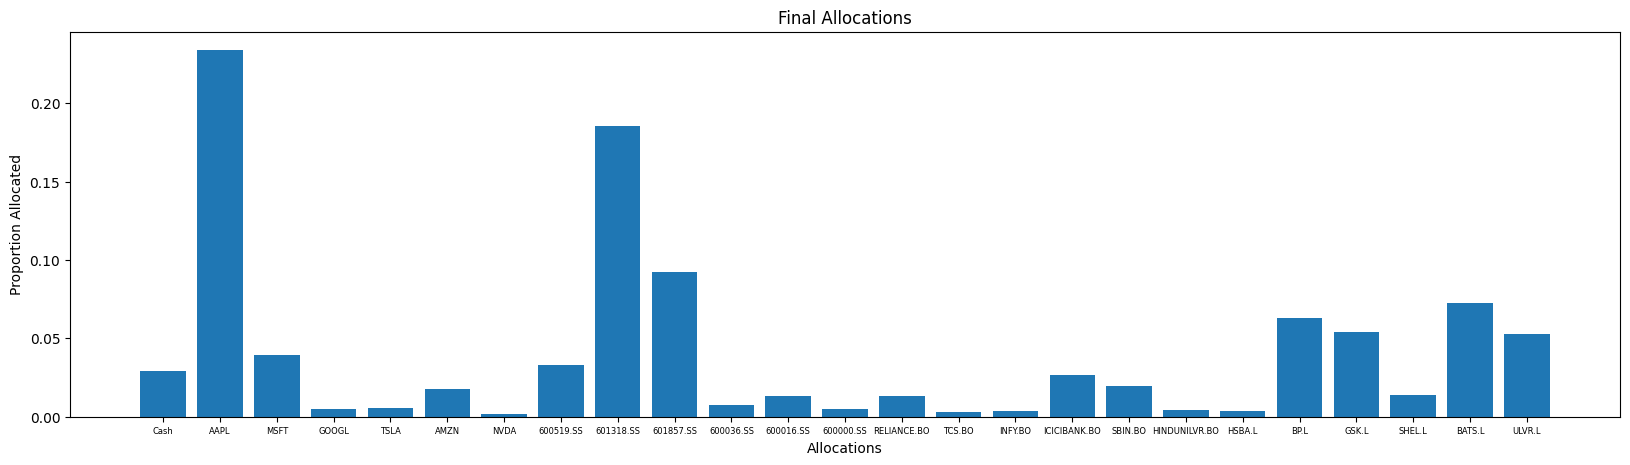

Risk Aversion: 0.5 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
2.18,13.23,47.4071,59.616,0.0052,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,0.5


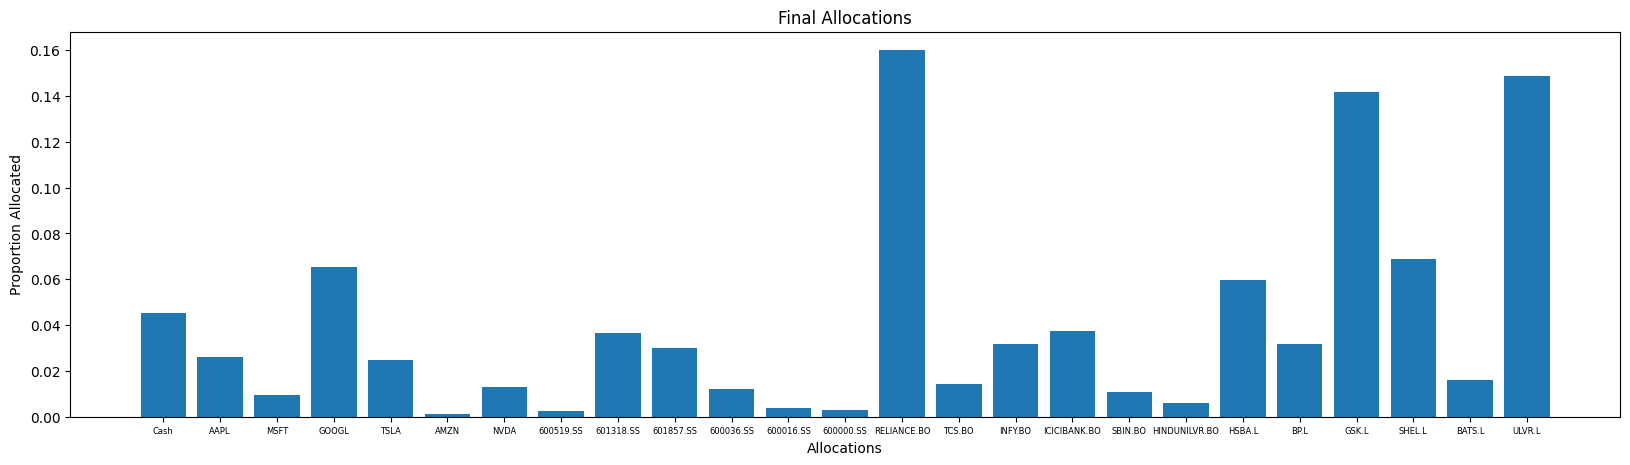

Risk Aversion: 0.5 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
43.03,49.97,49.3904,1175.59,0.1169,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,0.5


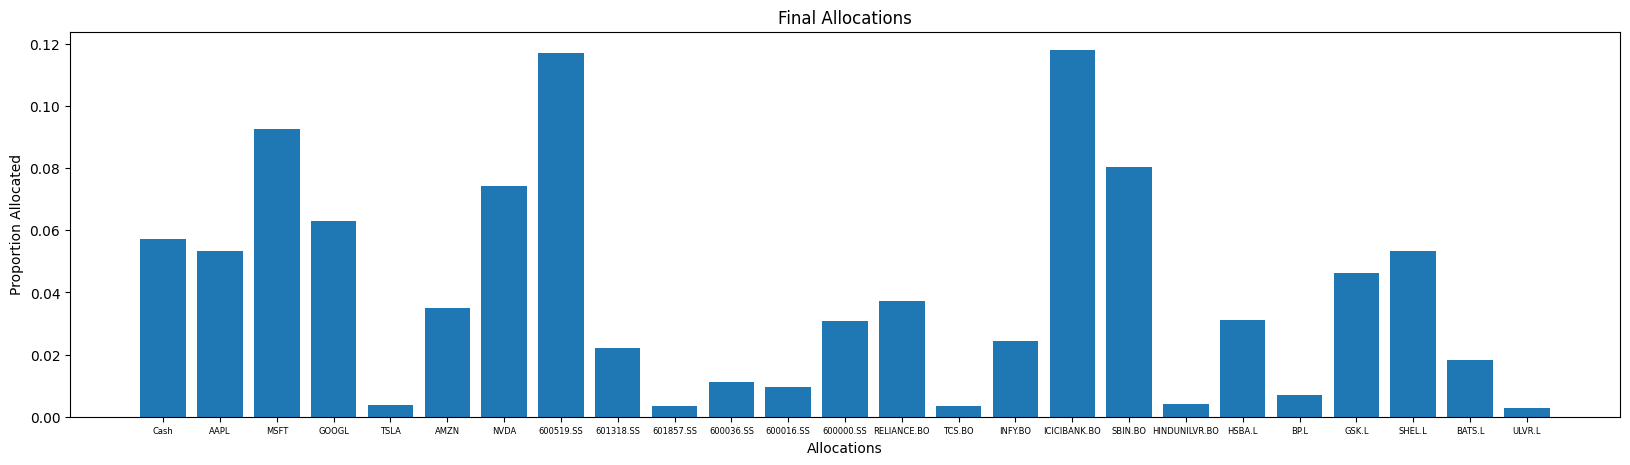

Risk Aversion: 0.5 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
10.03,21.71,44.7193,274.097,0.0218,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,0.5


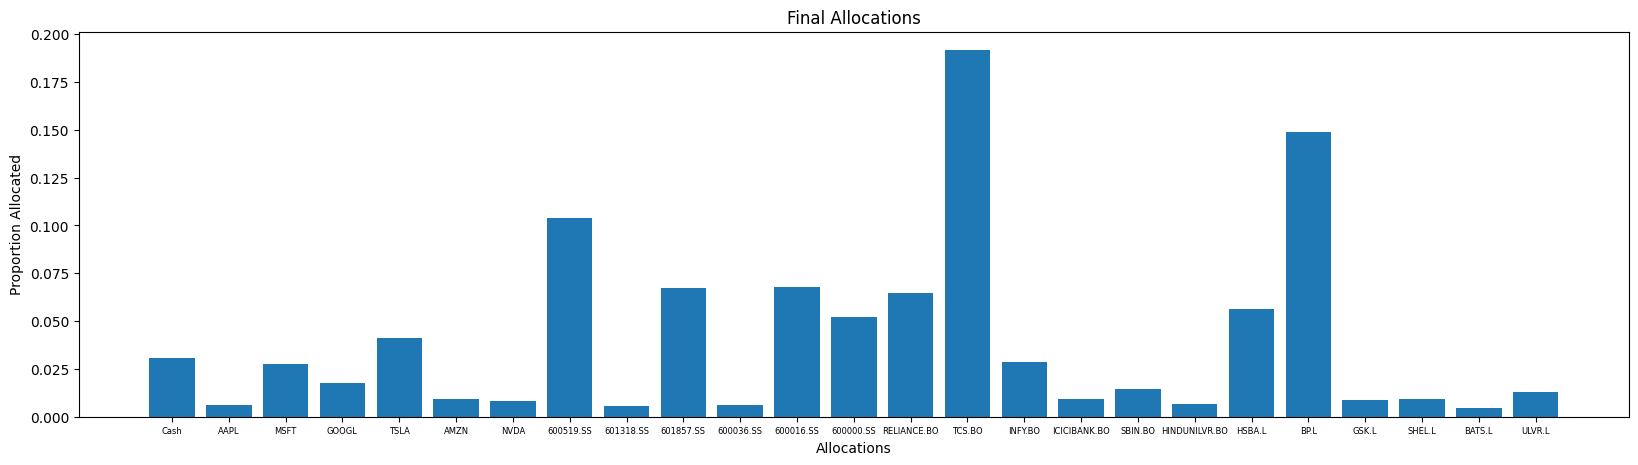

Risk Aversion: 1.0 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
45.17,48.25,45.3937,1234.27,0.1423,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1


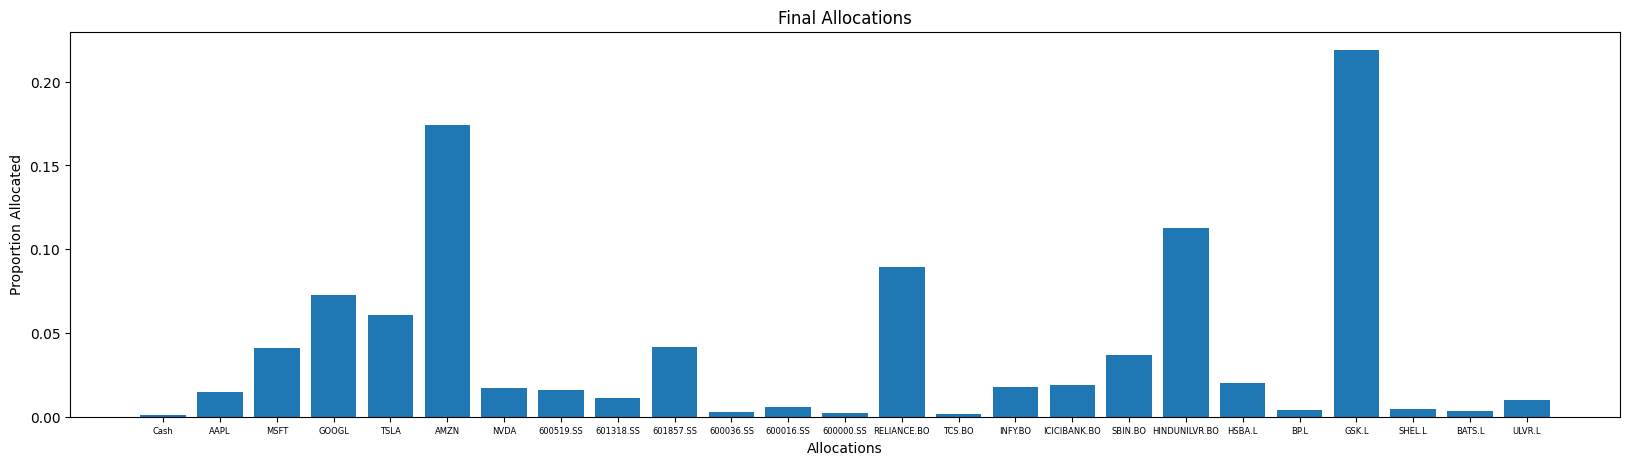

Risk Aversion: 1.0 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
14.99,19.86,47.3736,409.526,0.0325,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1


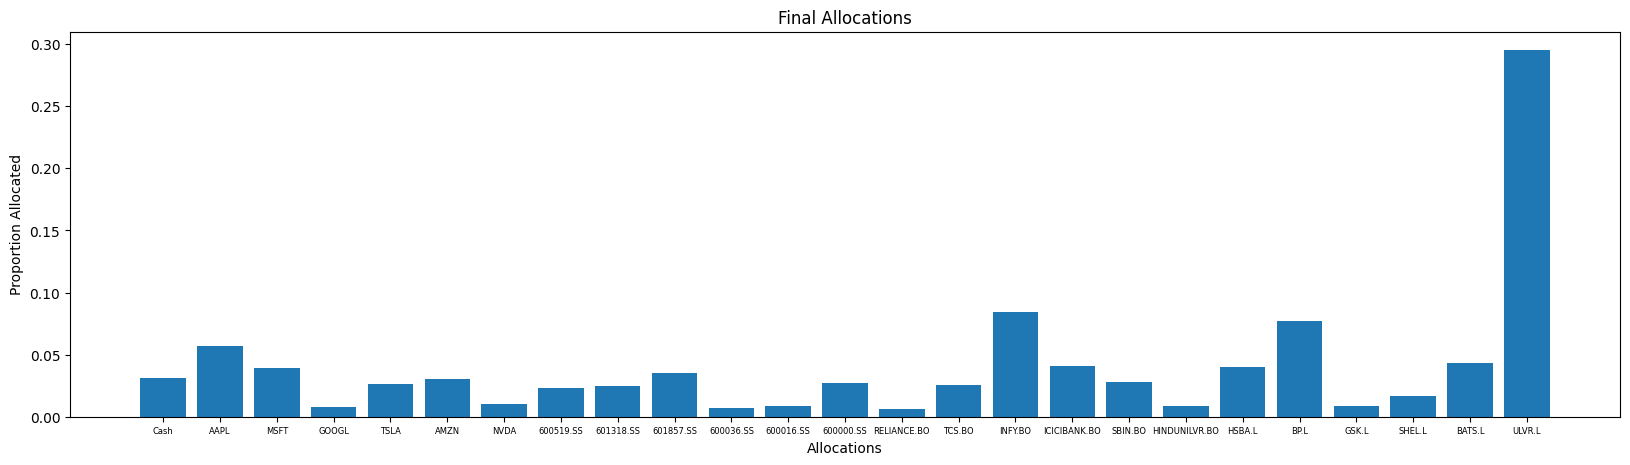

Strategy: RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.35,31.53,32.5071,747.383,0.0833,1101


Strategy: RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.76,20.3,52.4877,321.347,0.0245,1101


Risk Aversion: 1.0 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.45,39.79,35.5827,831.906,0.0887,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1


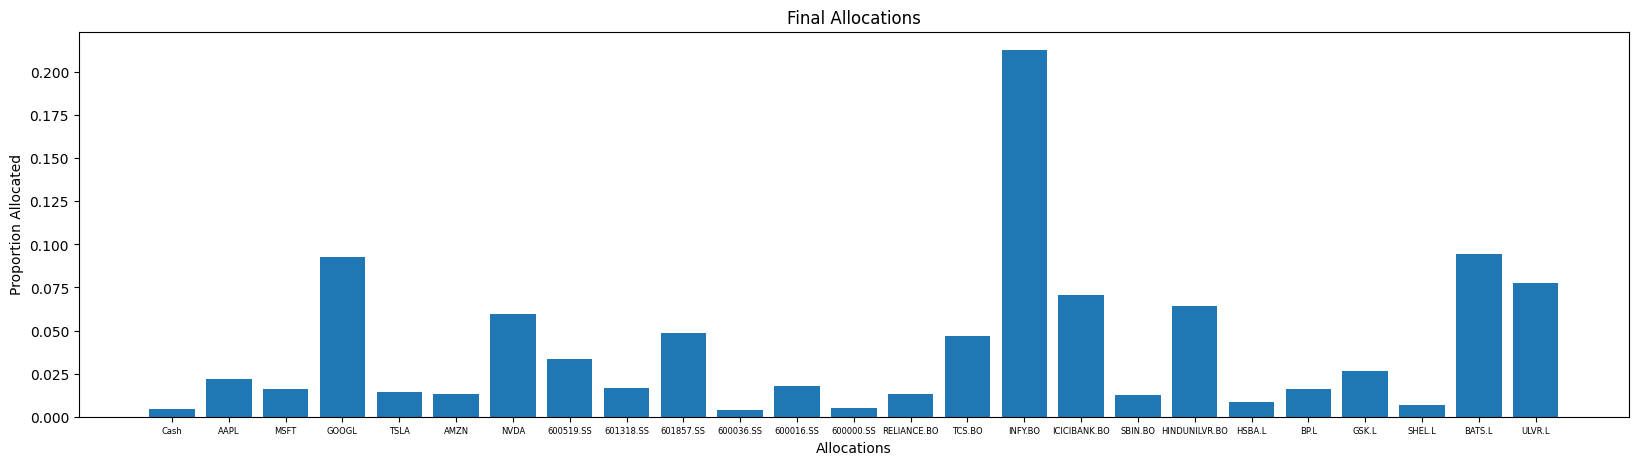

Risk Aversion: 1.0 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16.4,23.5,47.702,447.972,0.0332,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1


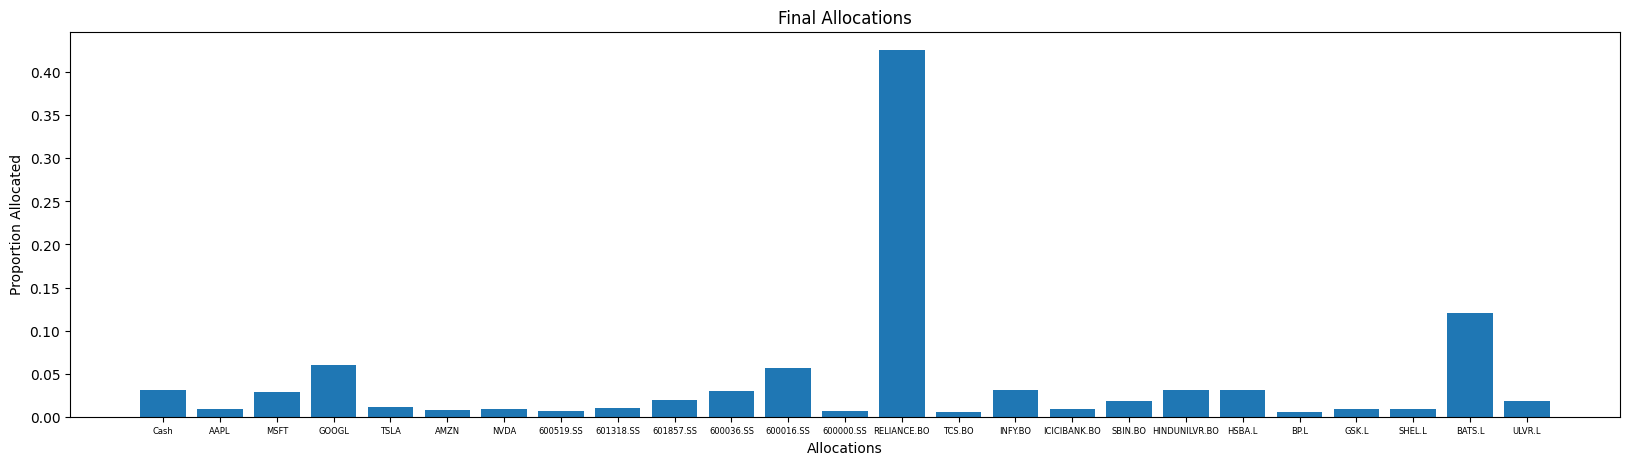

Risk Aversion: 1.0 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
32.31,39.06,43.8213,882.686,0.1009,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1


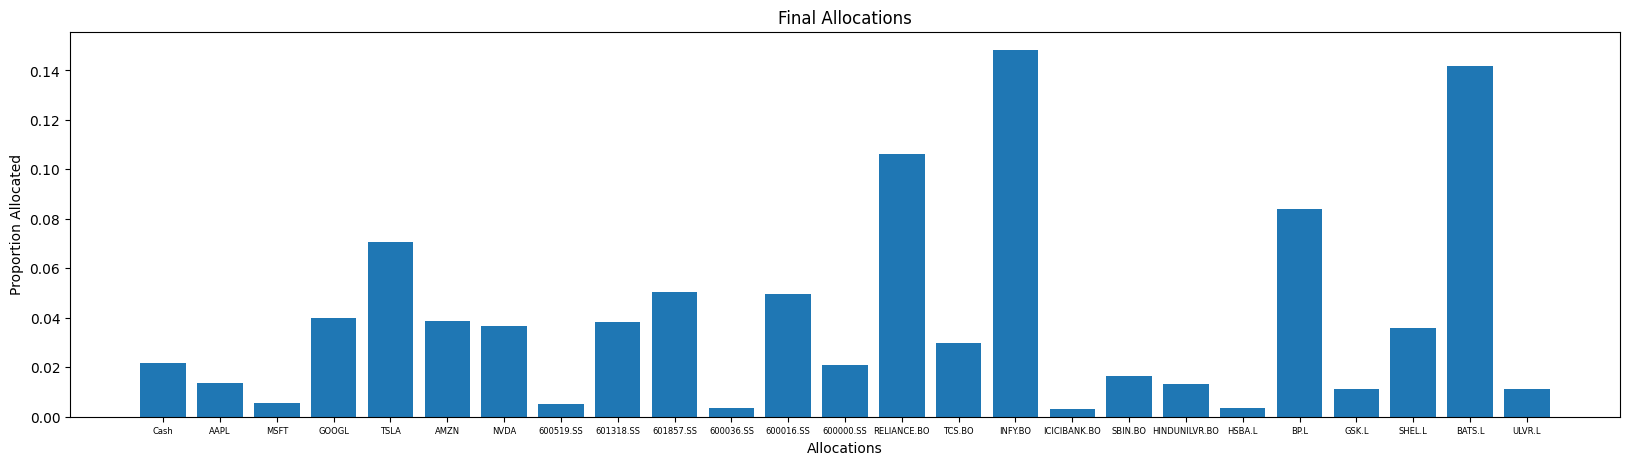

Risk Aversion: 1.0 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.52,22.08,46.5556,369.292,0.0293,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1


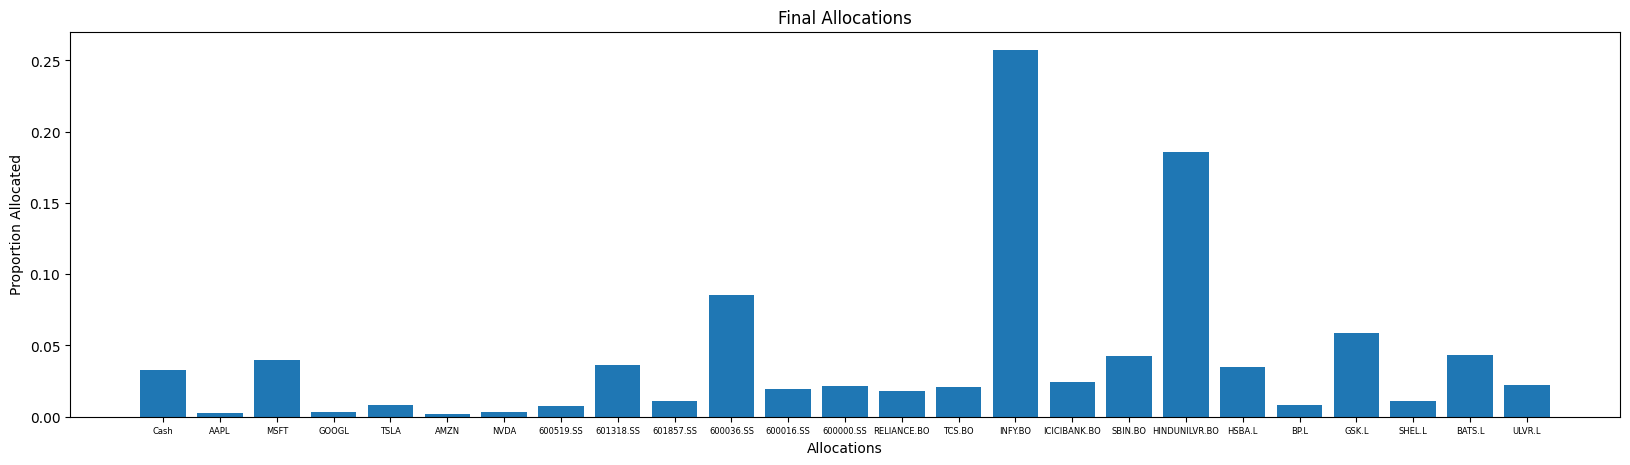

Risk Aversion: 1.0 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
40.69,49.55,36.9167,1111.85,0.0952,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1


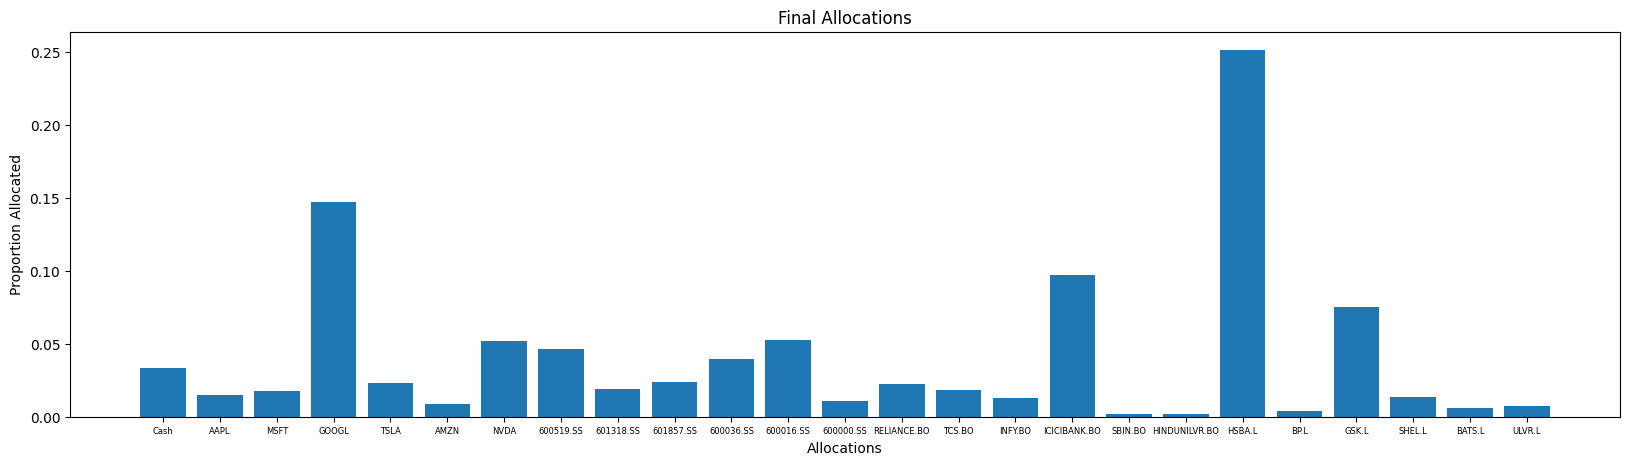

Risk Aversion: 1.0 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
22.66,29.72,47.9154,619.154,0.0436,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1


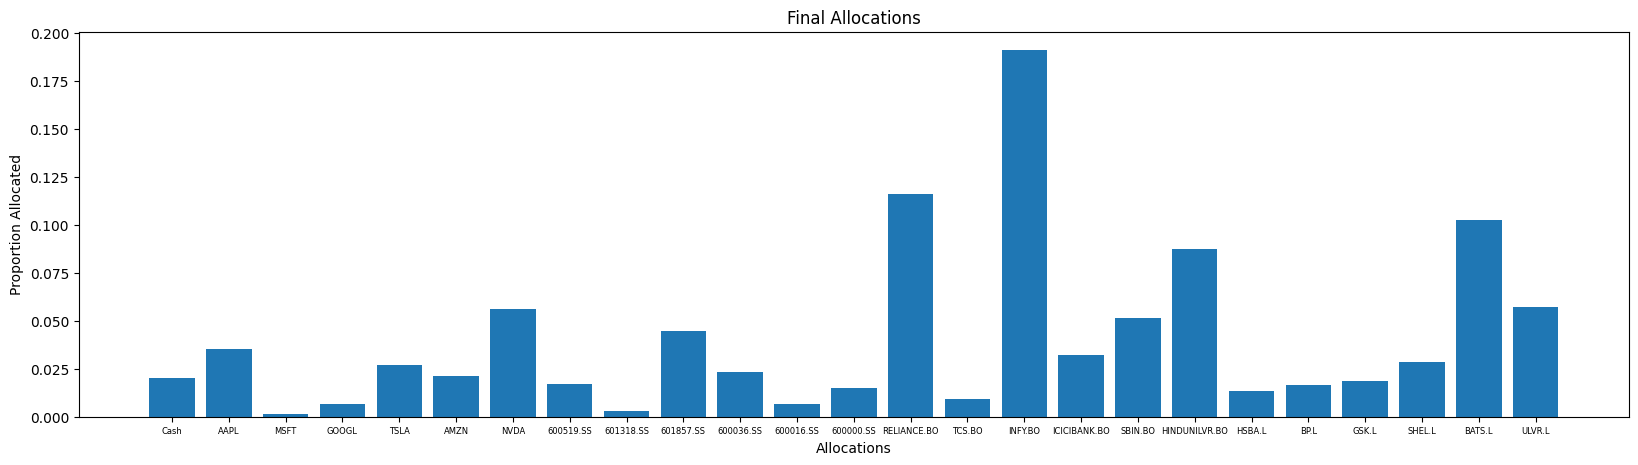

Risk Aversion: 1.0 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
35.09,39.77,38.3883,958.806,0.0966,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1


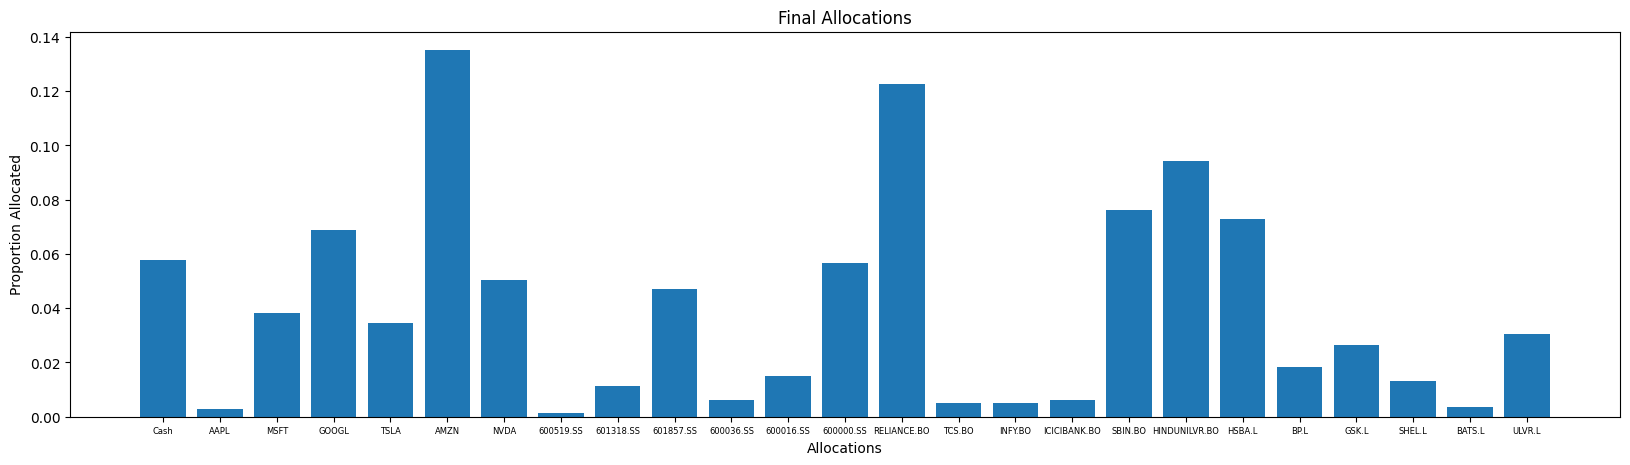

Risk Aversion: 1.0 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.44,21.89,46.7369,312.493,0.0233,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1


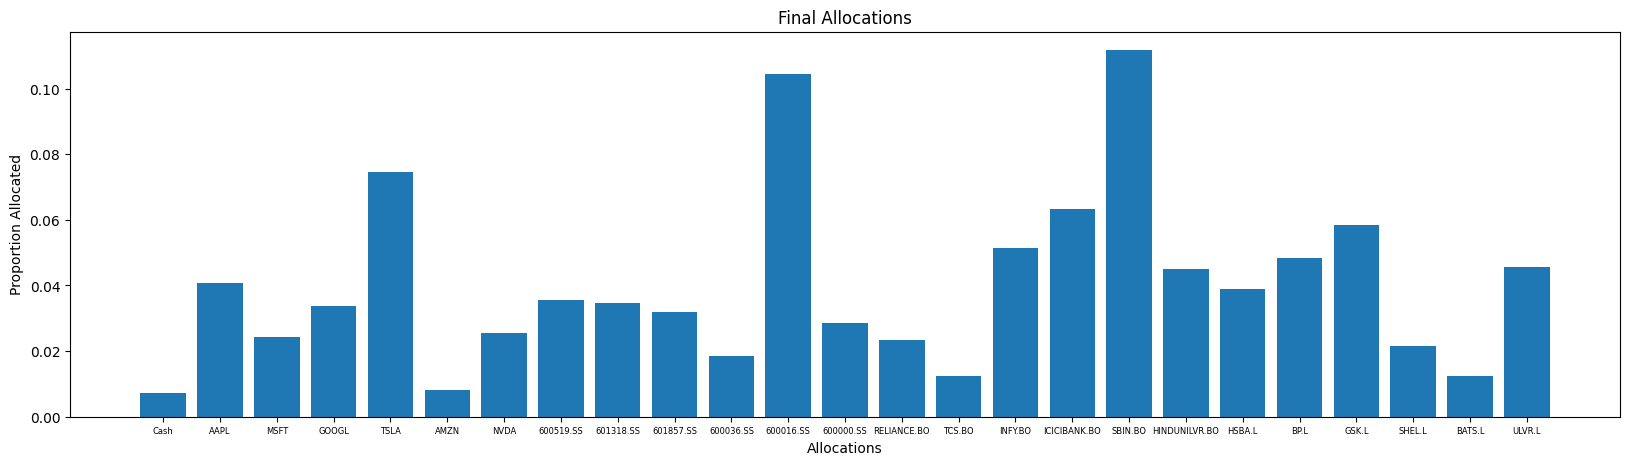

Risk Aversion: 1.5 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
38.31,40.96,38.2162,1046.69,0.1103,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1.5


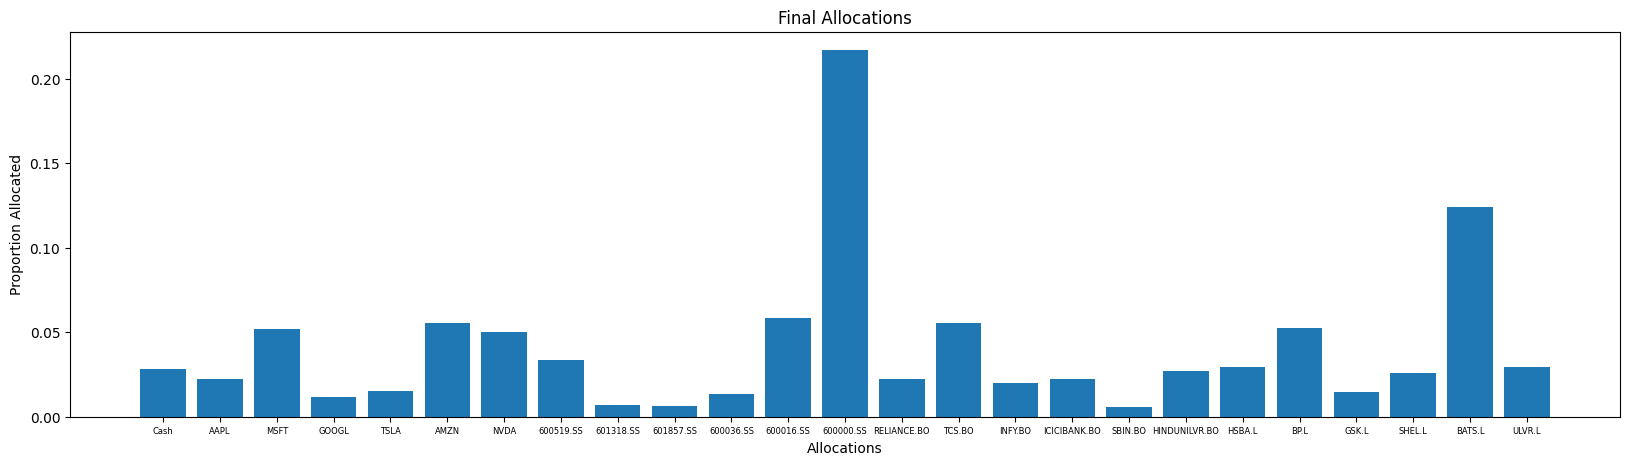

Risk Aversion: 1.5 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.6,22.81,45.7863,535.41,0.0421,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1.5


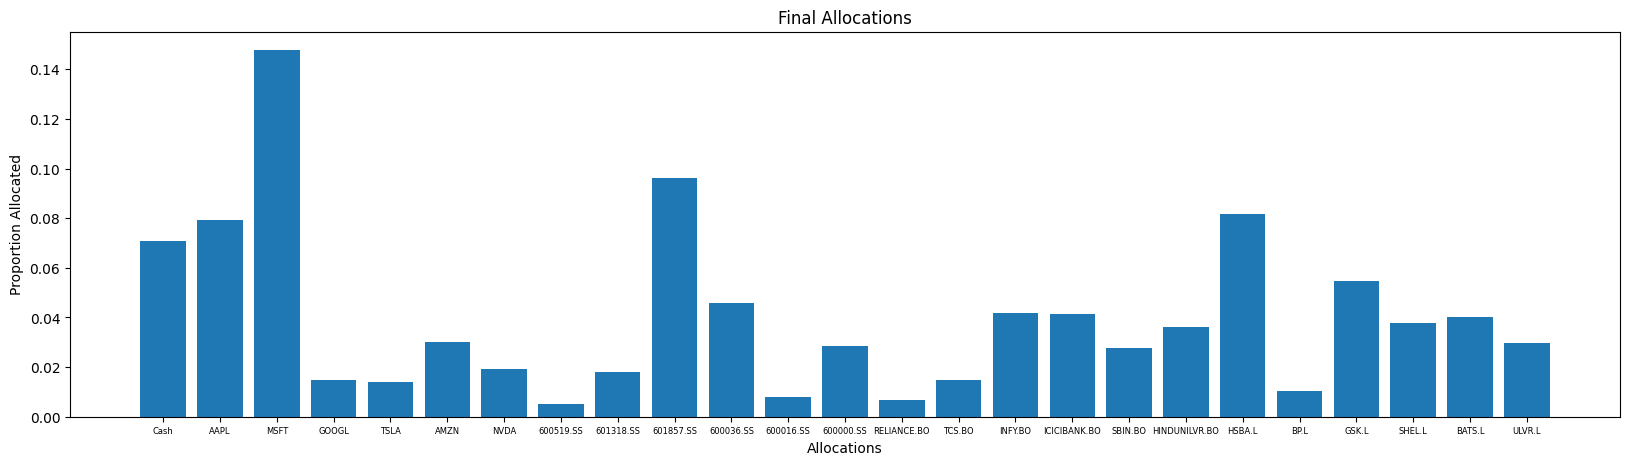

Strategy: RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
38.22,45.93,33.532,1044.31,0.1062,1101


Strategy: RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
7.99,15.45,50.0593,218.209,0.0176,1101


Risk Aversion: 1.5 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
40.03,40.99,40.1676,1093.79,0.116,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1.5


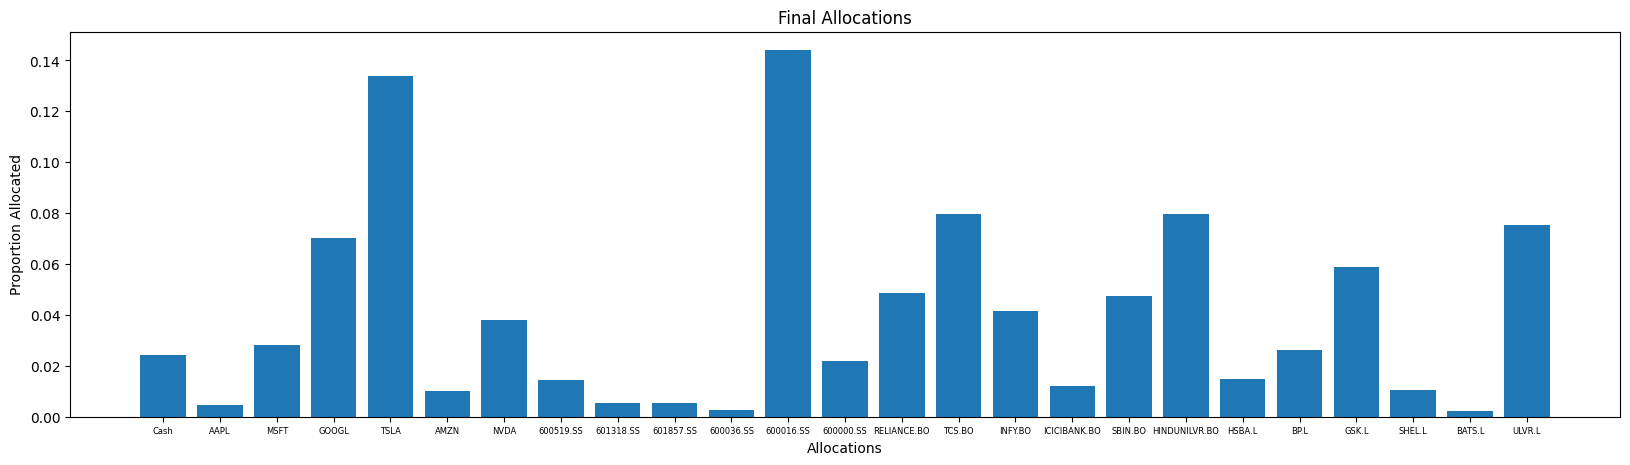

Risk Aversion: 1.5 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.77,30.55,45.1671,758.847,0.055,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1.5


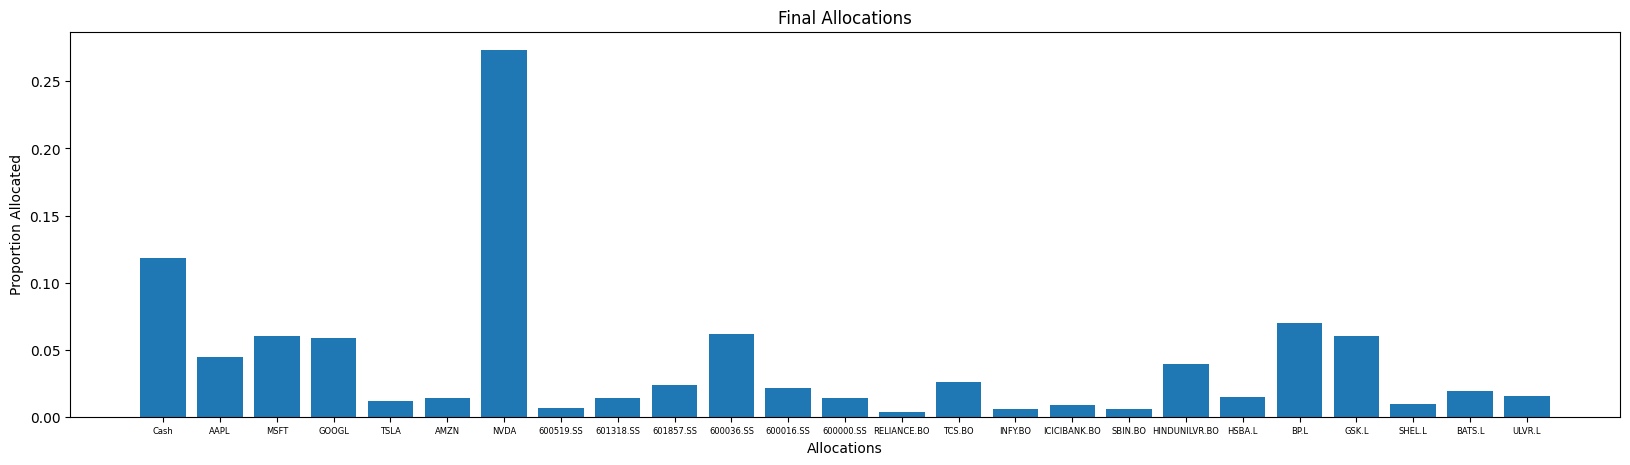

Risk Aversion: 1.5 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
39.32,41.11,34.9218,1074.3,0.1159,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1.5


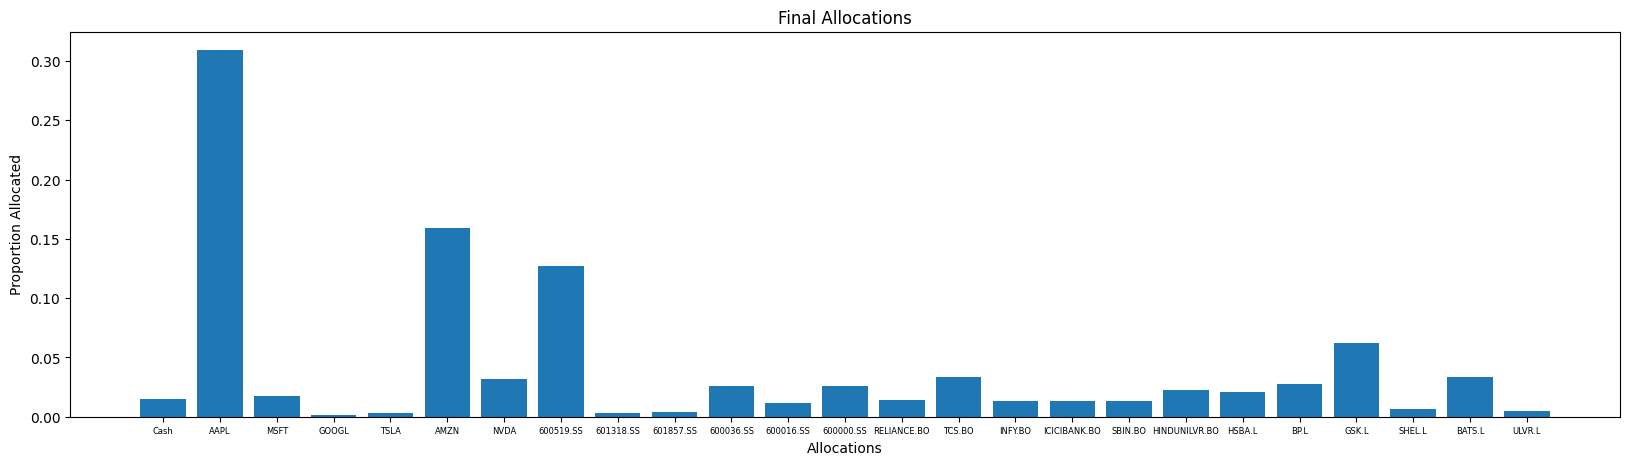

Risk Aversion: 1.5 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.56,22.04,45.5385,479.676,0.0384,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1.5


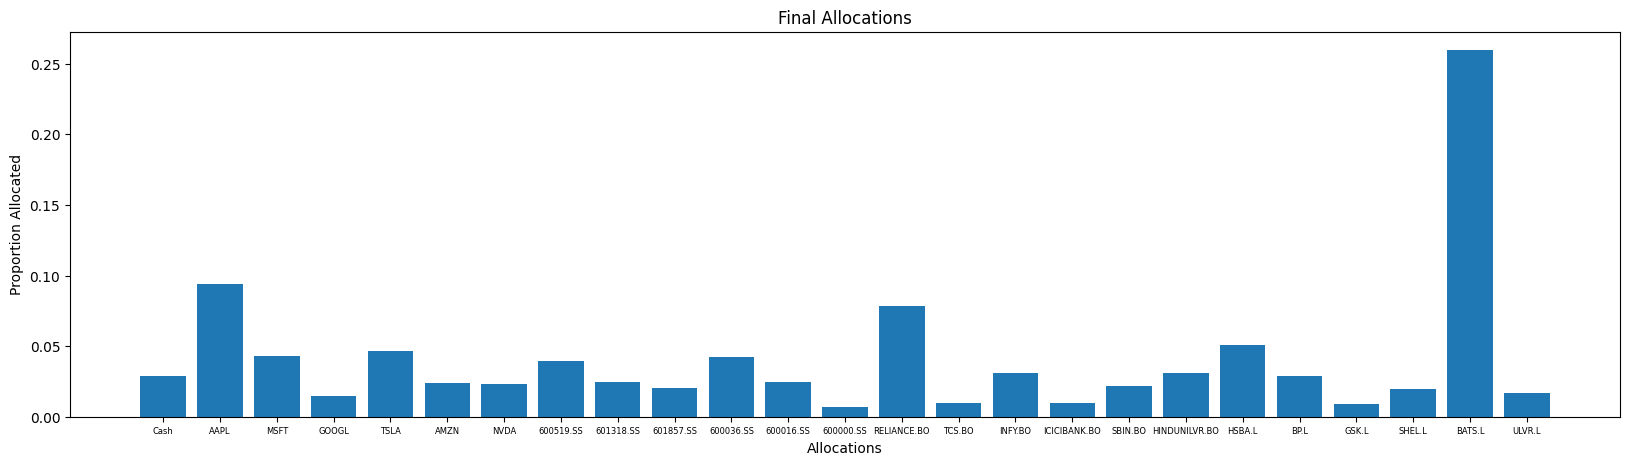

Risk Aversion: 1.5 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
35.33,43.57,45.3433,965.274,0.1005,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1.5


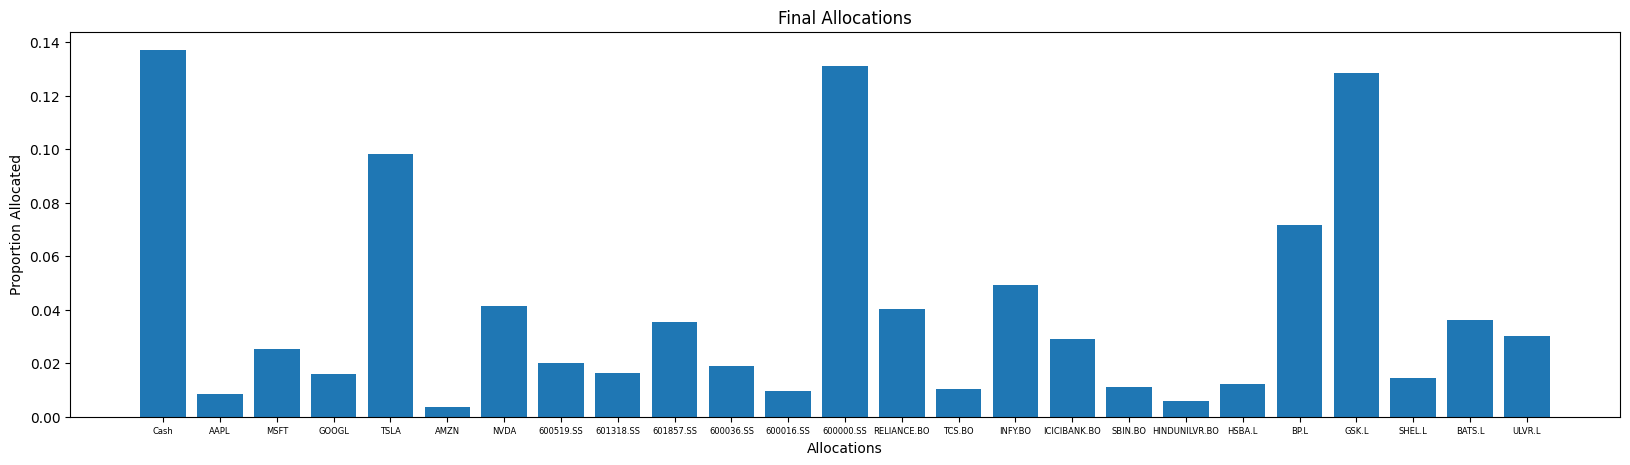

Risk Aversion: 1.5 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
10.42,22.82,51.326,284.815,0.0234,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1.5


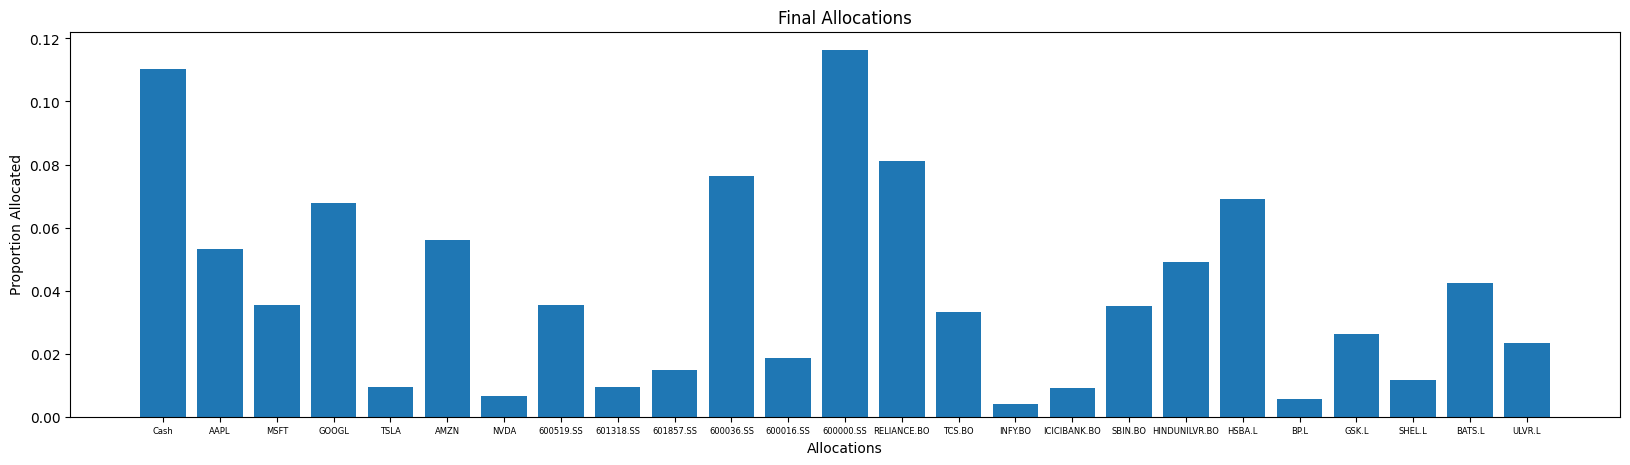

Risk Aversion: 1.5 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
32.7,37.98,33.364,893.417,0.098,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1.5


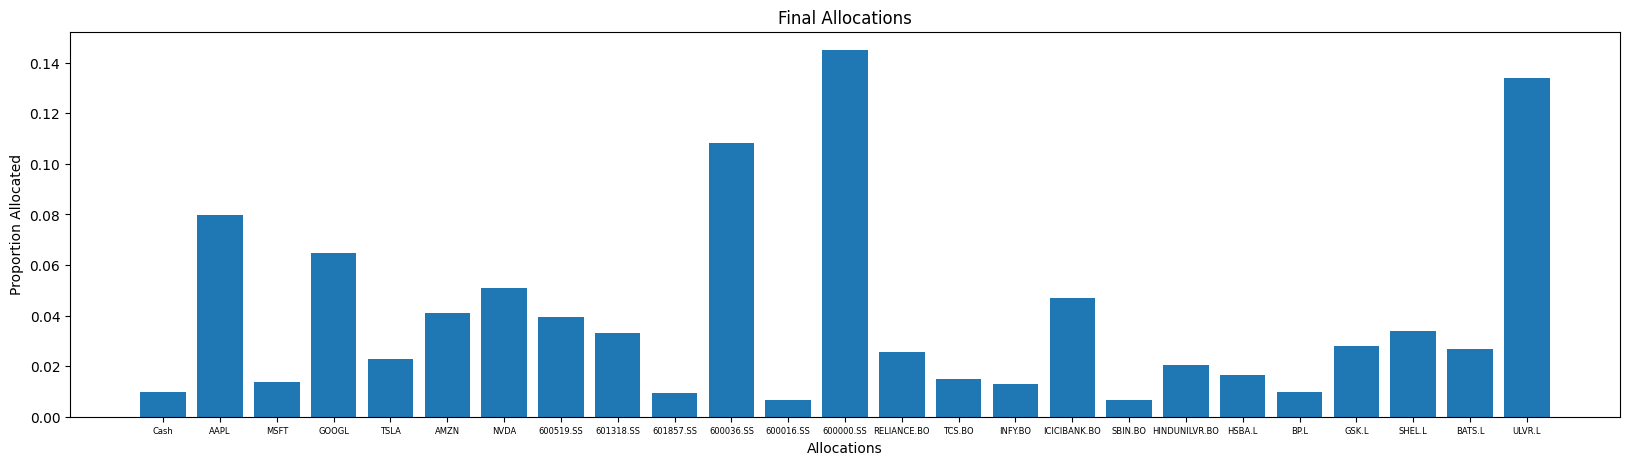

Risk Aversion: 1.5 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
6.84,13.77,46.673,186.914,0.0152,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,1.5


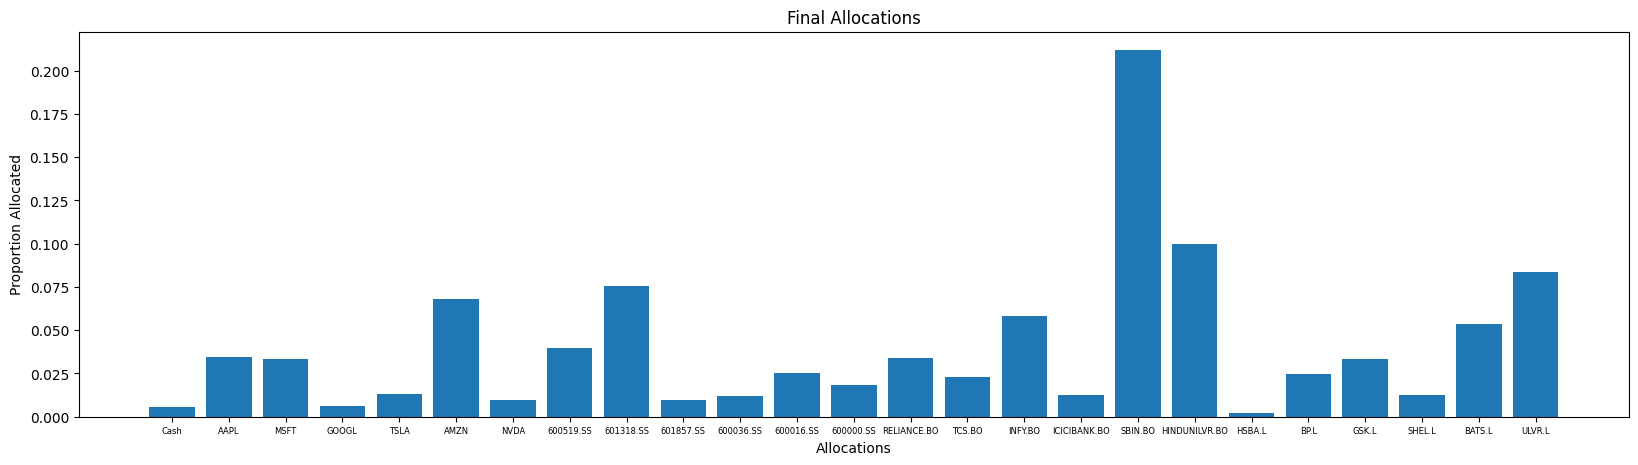

Risk Aversion: 2.0 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
33.34,38.11,40.9437,910.843,0.0926,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,2


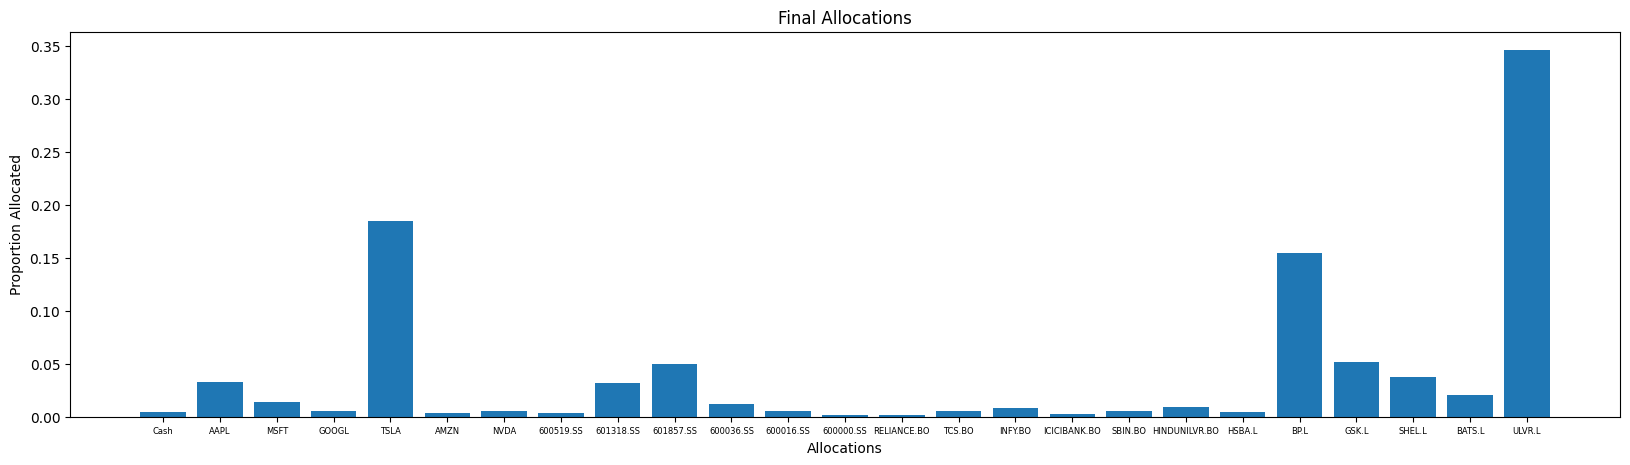

Risk Aversion: 2.0 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
2.49,14.41,48.5701,68.078,0.0056,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,2


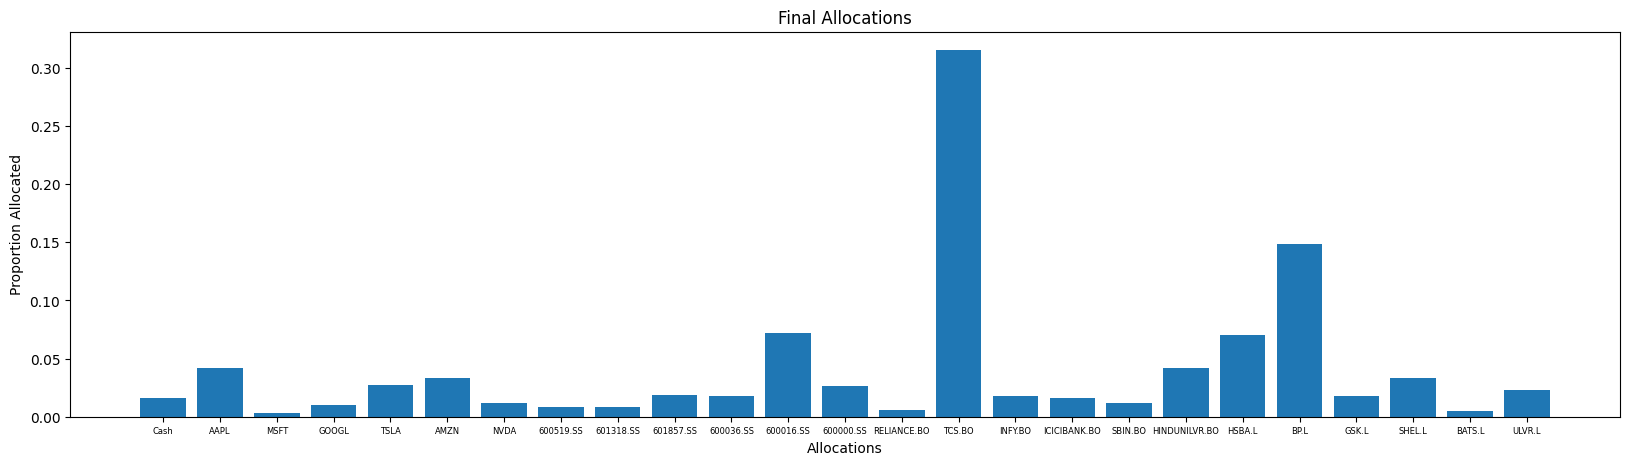

Strategy: RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
32.88,36.57,36.09,898.248,0.097,1101


Strategy: RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
9.19,17.64,48.4975,251.101,0.0205,1101


Risk Aversion: 2.0 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.94,42.35,45.8226,1009.17,0.1049,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,2


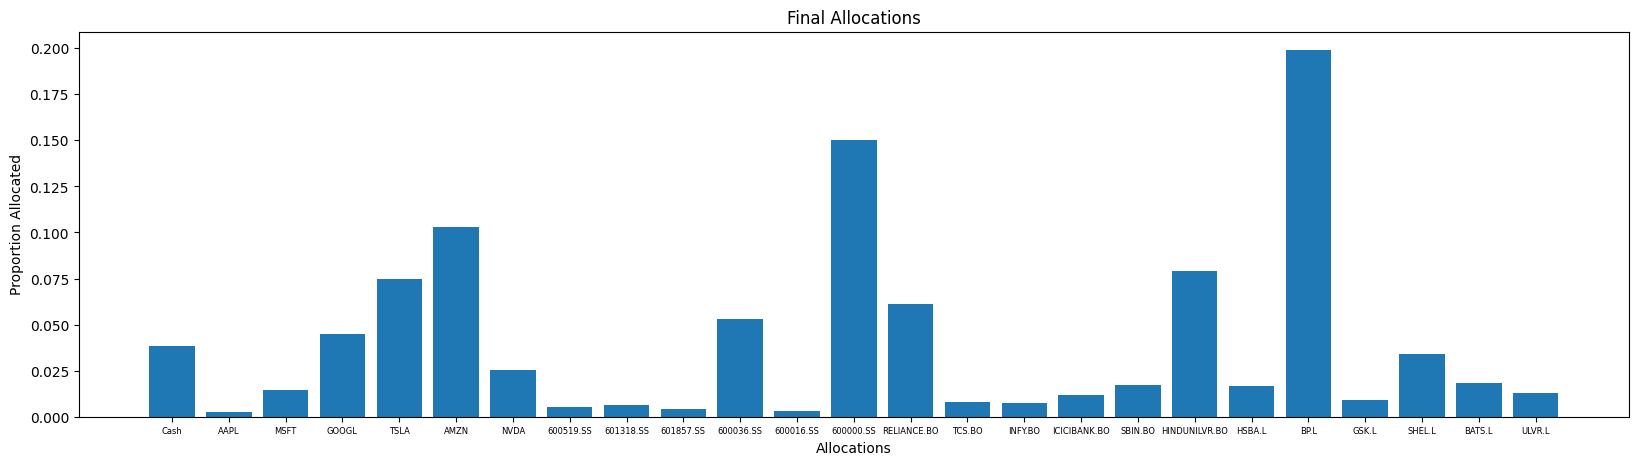

Risk Aversion: 2.0 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.22,34.67,48.5138,634.491,0.0451,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,2


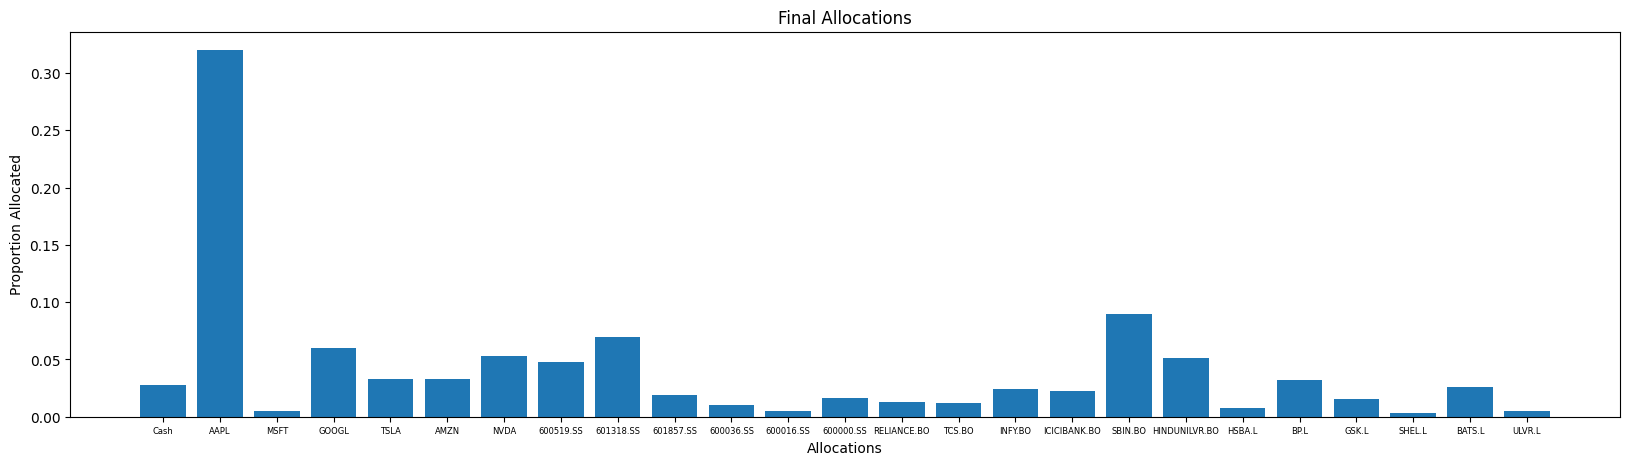

Risk Aversion: 2.0 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.46,31.94,39.6477,723.048,0.0756,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,2


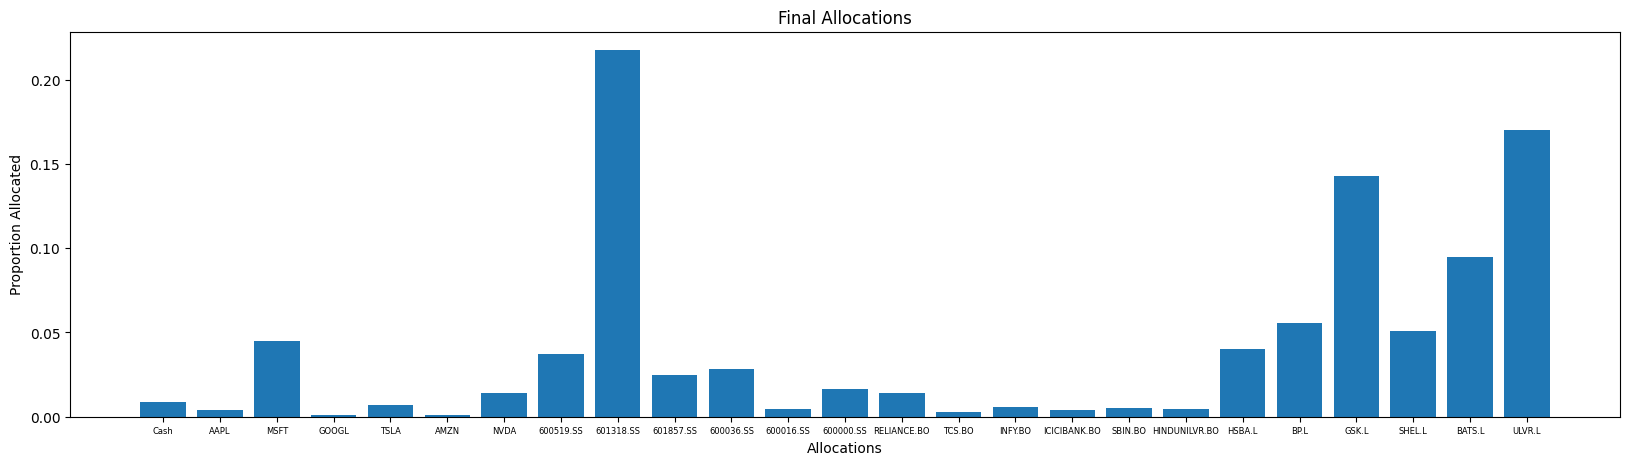

Risk Aversion: 2.0 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.71,25.1,48.8423,538.389,0.0431,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,2


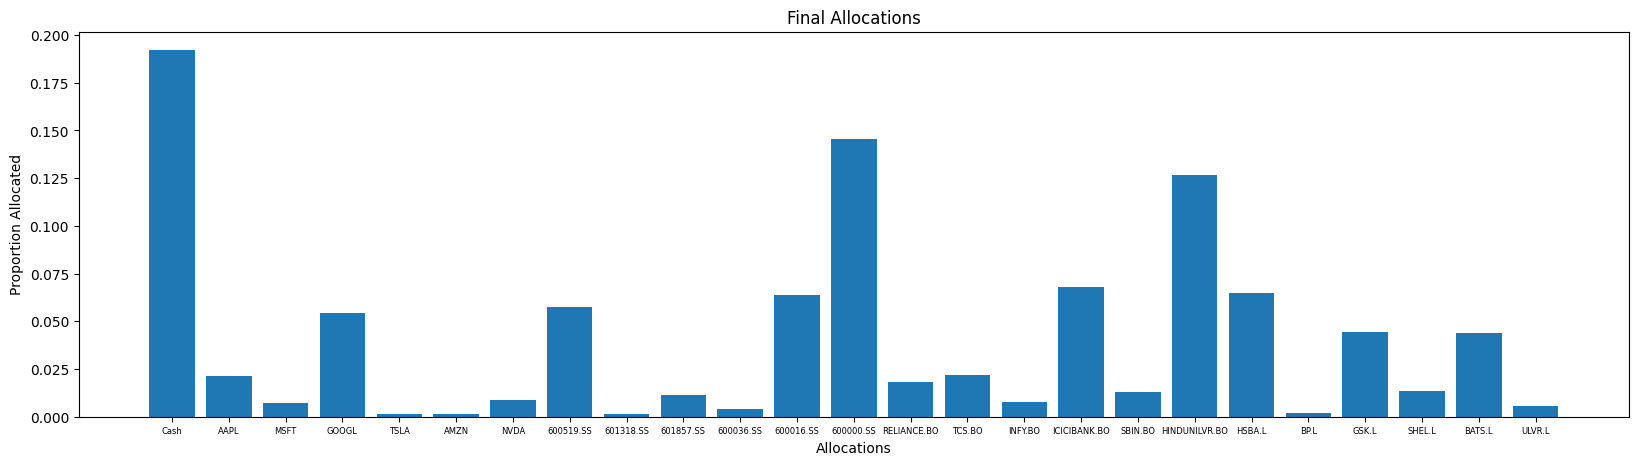

Risk Aversion: 2.0 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
40.22,45.12,39.9681,1098.96,0.1058,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,2


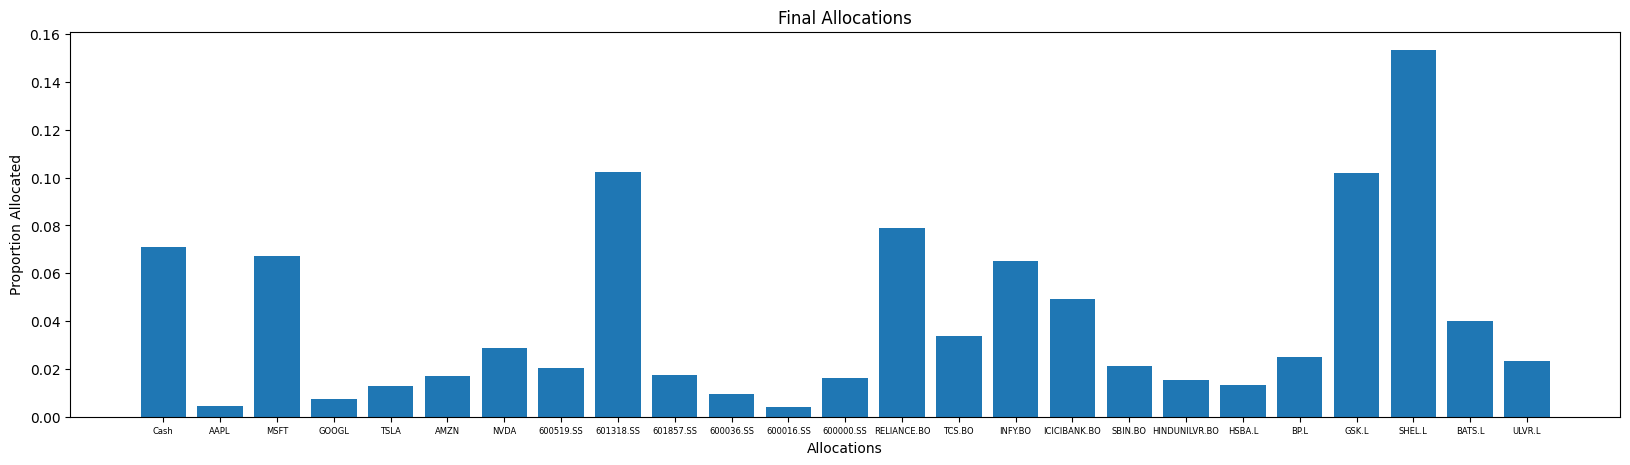

Risk Aversion: 2.0 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.51,30.07,51.5765,724.314,0.0511,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,2


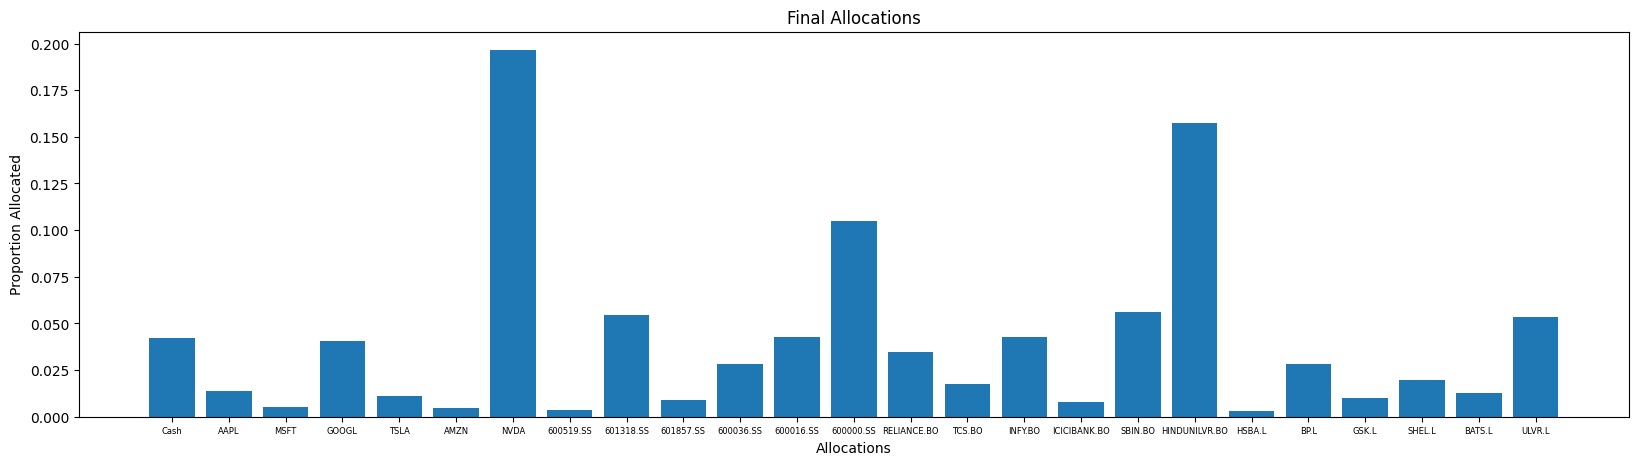

Risk Aversion: 2.0 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
46.84,50.39,38.1382,1279.69,0.129,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,2


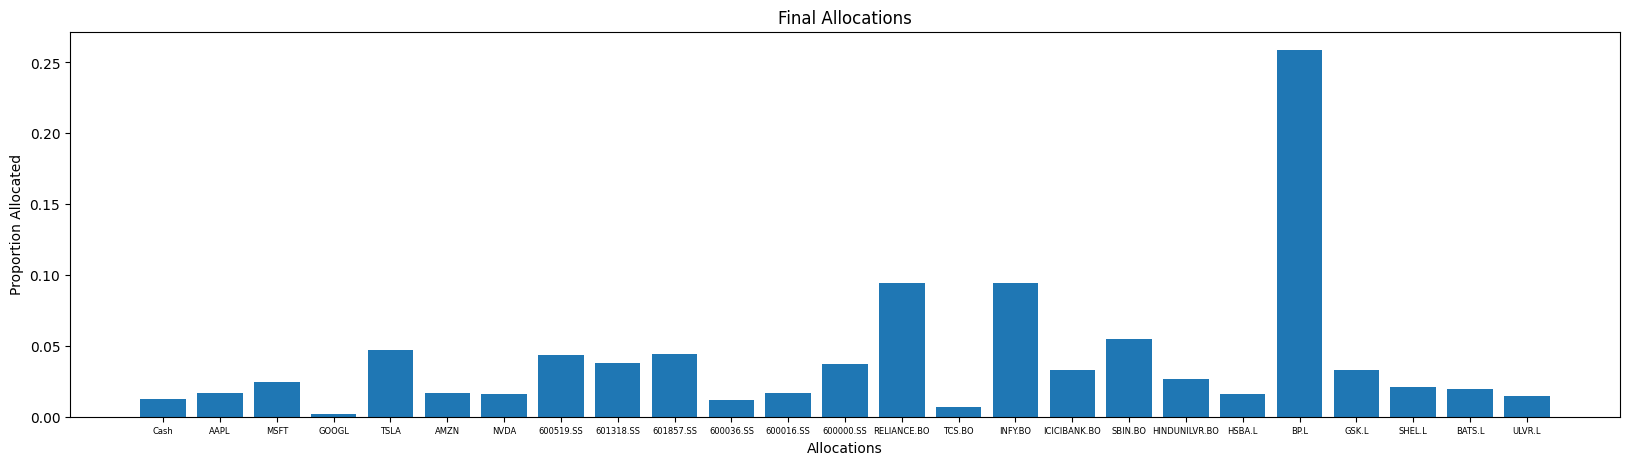

Risk Aversion: 2.0 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
21.56,23.12,51.3861,589.15,0.0444,1101


Configuration:

LSTM Hidden Size,LSTM Output Size,Learning Frequency,Agent Risk Aversion
128,192,44,2


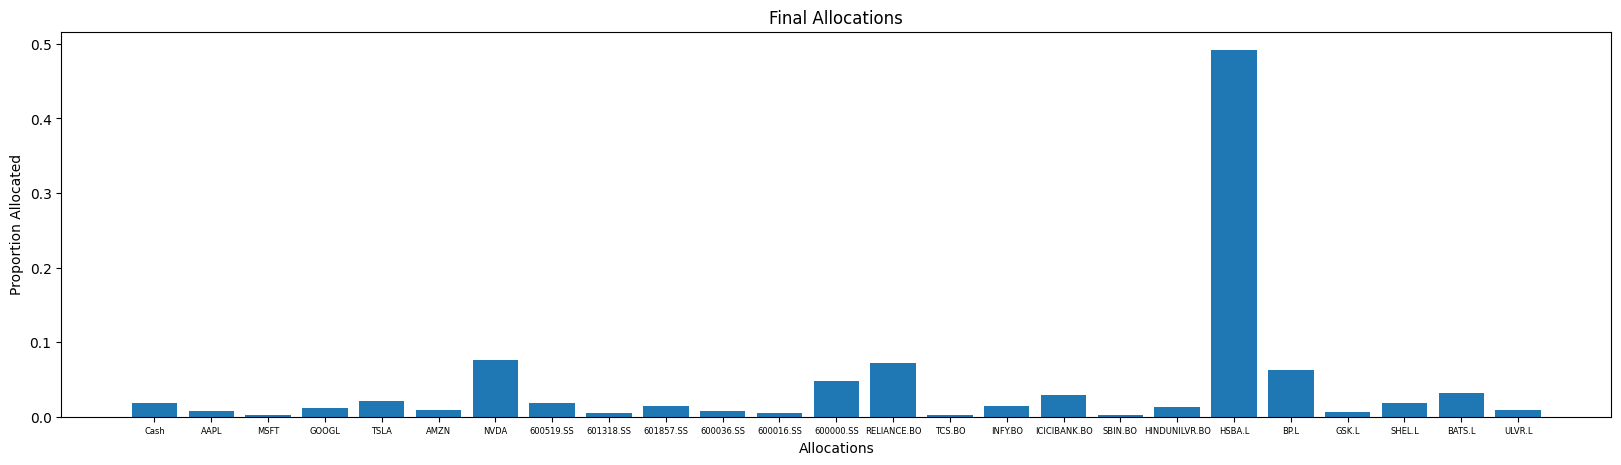

In [14]:
def test():
    if TESTING["RISK_AVERSION"]:
        print("TESTING RISK AVERSION")
        for risk in AGENT_RISK_AVERSIONS:
            trainingLoop(riskAversion=risk)
    elif TESTING["LSTM_OUTPUT_SIZE"]:
        print("TESTING LSTMOUTPUTSIZE")
        for size in LSTMOUTPUTSIZES:
            trainingLoop(lstmOutputSize=size)
    elif TESTING["REWARD_FUNCTION"]:  
        print("TESTING REWARD FUNCTION")
        for r in REWARD_FUNCTIONS:
            trainingLoop(rewardFunction=r)
    elif TESTING["LEARNING_FREQUENCY"]:
        print("TESTING LEARNING FREQUENCY")
        for fr in LEARNING_FREQUENCIES:
            trainingLoop(freq=fr)

for key, value in TESTING.items():
    TESTING[key] = True
    test()
    TESTING[key] = False
    break

### Visualise Performance ###

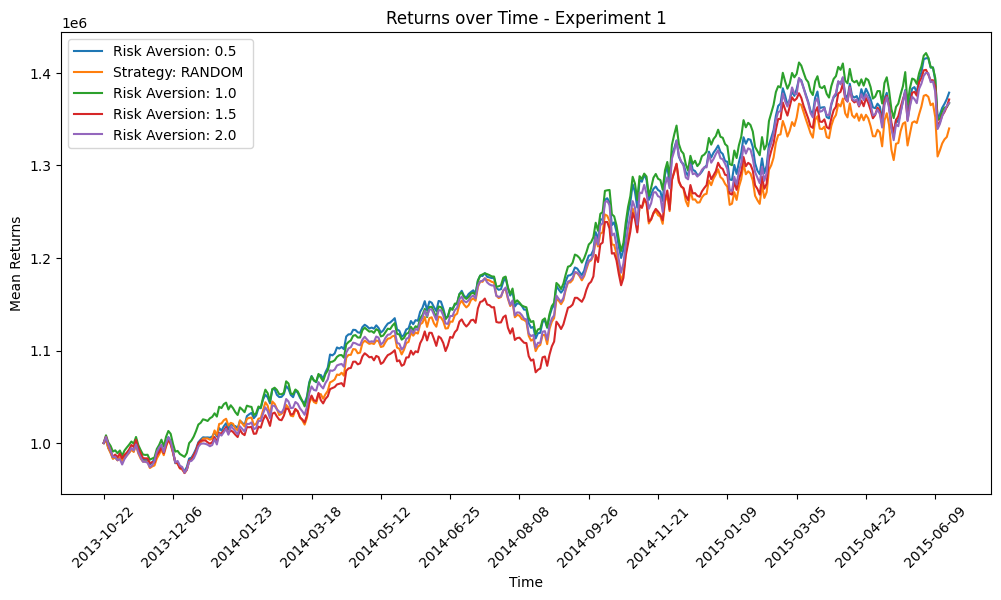

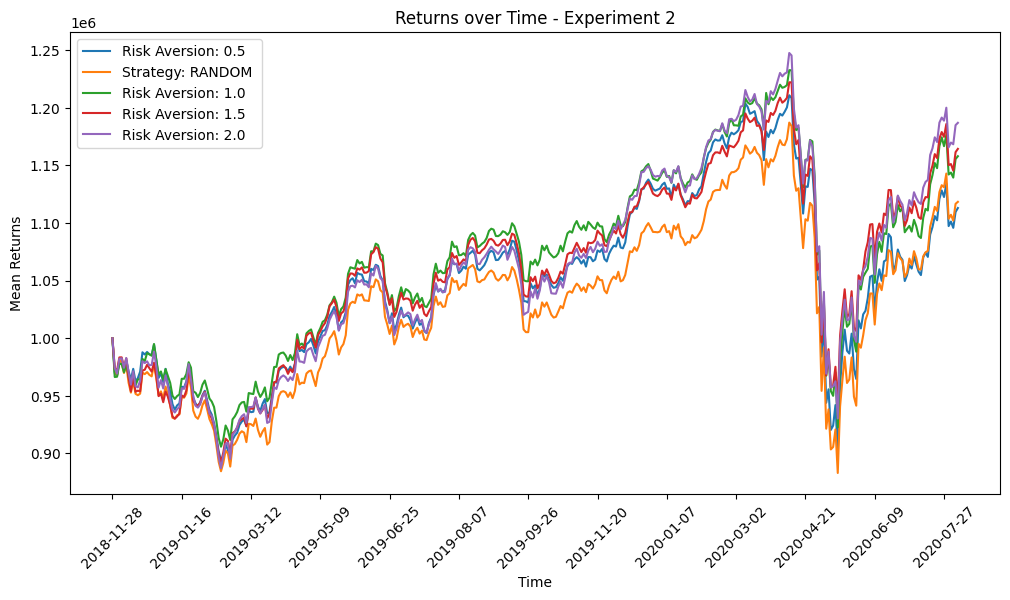

In [17]:
result = np.array_split(times, STARTS, axis=0)[1:]
timeScale = []
for dates in result:
    # print(type(dates[0]))
    # dates = np.datetime_as_string(dates.values, unit='D')
    timeScale.append(dates)

for experiment in range(EXPERIMENTS):
    plt.figure(figsize=(12,6))
    for k, v in averagePerformance.items():
        shouldBeSkipped = False
        for value in list(NON_RL_COMPARISON_STRATEGIES.keys())[:-1]:
            if value in k:
                shouldBeSkipped = True # only need to compare with buy and hold for now
        if shouldBeSkipped:
            continue
        v = np.array(v)
        v = np.mean(v, axis=0)
        if f"Experiment {experiment + 1}" in k:
            array = np.insert(v[int(2/3 * TRAINING_PERIODS) + 2:], 0, START_CASH)
            labels = timeScale[experiment][-len(array):]
            labelIndices = range(0, len(labels), 30)  
            plt.xticks(labelIndices, rotation=45)
            plt.plot(labels, array, label=k.split("|")[0]) ## too tired
    plt.title(f"Returns over Time - Experiment {experiment + 1}")
    plt.xlabel("Time")
    plt.ylabel("Mean Returns")
    plt.legend()
    plt.savefig(f"plots/Results-Experiment_{experiment + 1}_" + datetime.now().strftime("%Y-%m-%d_%H_%M_%S"))
    plt.show()



### Mean, Tabled Results

In [16]:
for k, v in allResults.items():
    table = [list(v[0].keys()) + ["Standard Deviation"]] 
    meanReturns, meanMER, meanPB, meanAPPT, meanSR, timeSteps = 0, 0, 0, 0, 0, 0
    deviations = []
    for resultSet in v:
        meanReturns += resultSet["Cumulative \nReturn (%)"]
        deviations.append(resultSet["Cumulative \nReturn (%)"])
        meanMER += resultSet["Maximum Earning \nRate (%)"]
        meanPB += resultSet["Maximum \nPullback (%)"]
        meanAPPT += (resultSet["Average Profitability \nper Trade"] if type(resultSet["Average Profitability \nper Trade"]) == int else 0)
        meanSR += resultSet["Sharpe Ratio"]
        timeSteps += resultSet["Total Timesteps"]
    array = [meanReturns, meanMER, meanPB, meanAPPT, meanSR, timeSteps, np.std(deviations)]
    array = [i/len(v) for i in array]
    table.append(array)
    tabulate_neatly(table, headers="firstrow", title="MEAN RESULTS FOR: " + k)

MEAN RESULTS FOR: Risk Aversion: 0.5 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
37.878,42.888,38.9497,0,0.10622,1101,1.51762


MEAN RESULTS FOR: Risk Aversion: 0.5 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
11.304,21.92,46.8159,0,0.02268,1101,1.13162


MEAN RESULTS FOR: Strategy: RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
34.0025,38.46,35.3166,0,0.099325,1101,1.08943


MEAN RESULTS FOR: Strategy: RANDOM | | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
11.8425,19.02,50.3283,0,0.024875,1101,1.00995


MEAN RESULTS FOR: Risk Aversion: 1.0 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
36.742,43.284,40.0205,0,0.10474,1101,1.09024


MEAN RESULTS FOR: Risk Aversion: 1.0 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
15.802,23.41,47.2567,0,0.03238,1101,0.76044


MEAN RESULTS FOR: Risk Aversion: 1.5 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
37.138,40.922,38.4026,0,0.10814,1101,0.547453


MEAN RESULTS FOR: Risk Aversion: 1.5 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
16.438,22.398,46.8982,0,0.03482,1101,1.46427


MEAN RESULTS FOR: Risk Aversion: 2.0 | Strategy: PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
36.76,41.582,40.9041,0,0.10158,1101,1.36058


MEAN RESULTS FOR: Risk Aversion: 2.0 | Strategy: PPOLSTM | Experiment 2

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps,Standard Deviation
18.698,25.474,49.7778,0,0.03786,1101,1.6814
